# Segmentarea Semantică pe Imagini

Segmentarea imaginii este sarcina de **împărțire a unei imagini în segmente** care reprezintă zone semnificative — cum ar fi obiecte, limite sau regiuni — astfel încât fiecare pixel să fie grupat cu altele similare pentru o analiză sau procesare mai ușoară.

Tipuri de segmentare:
- *Segmentare semantică:* Clasifică fiecare pixel într-o categorie (de exemplu, drum, mașină, cer), dar nu face distincție între diferite instanțe ale aceleiași clase.
- *Segmentare de instanță:* La fel ca segmentarea semantică, dar face distincție între diferite obiecte ale aceleiași clase (de exemplu, persoana 1 vs persoana 2).
- *Segmentare panoptică:* Combină segmentarea semantică și segmentarea instanțelor.

<img src="https://framerusercontent.com/images/NmCpA7nkioxThQfDHdxdMBaLcU.png?width=1240&height=1324" width="50%" />

*[image source]([[source=https://www.v7labs.com/blog/image-segmentation-guide]])*

### Cum funcționează
Segmentarea imaginii funcționează prin atribuirea unei etichete fiecărui pixel dintr-o imagine, astfel încât pixelii cu aceeași etichetă să aibă anumite caracteristici comune. Aceste caracteristici pot fi bazate pe:
* **Culoare:** gruparea pixelilor cu valori de culoare similare.
* **Textură:** identificarea regiunilor cu modele sau texturi similare.
* **Discontinuități:** detectarea schimbărilor bruște ale valorilor pixelilor, care indică adesea margini și limite.


### Tehnici de segmentare
- *Tehnici CV/ML:*
    - **Edge-based** segmentation: Se concentrează pe identificarea limitelor dintre regiunile separate dintr-o imagine.
    - **Threshold-based** segmentation: Utilizează praguri (thresholds) pentru a separa pixelii în diferite grupuri.
    - **Clustering**-based segmentation: Aplică algoritmi de clusterizare (de exemplu, k-means) pentru a separa pixelii în diferite grupuri.
- **_Tehnici Deep Learning:_** Utilizarea rețelelor neuronale, precum U-Net și ResNet.

### Aplicații practice

*   *Medical imaging:* Identificarea tumorilor sau organelor.
*   *Autonomous driving:* Detectarea benzilor de circulație, pietonilor, vehiculelor.
*   *Satellite imagery:* Segmentarea pădurilor, drumurilor, apelor.
*   *Photo editing:* Izolarea obiectelor pentru aplicarea filtrelor sau eliminarea fundalului.

### Librării

In [1]:
import cv2 # Computer Vision
import numpy as np # Numerical Operations
import matplotlib.pyplot as plt # Visualization
from matplotlib.colors import BoundaryNorm
from PIL import Image

import torch
import torch.nn as nn # Neural Networks
import torch.nn.functional as F # Functional operations related Neural Networks
import torch.optim as optim # Optimization Operations
from torch.utils.data import random_split, DataLoader # Data

import torchvision # Computer Vision utils for Machine Learning
import torchvision.transforms as transforms

seed = 42
np.random.seed(seed) # Ensures NumPy generates the same random numbers each run
torch.manual_seed(seed) # same, but for PyTorch
torch.cuda.manual_seed(seed)

### Toolkit cu diverse utilități pentru vizualizare

In [42]:
class VisualizationToolkit:
    _cmap = plt.get_cmap("tab20")
    _norm = BoundaryNorm(np.arange(-0.5, 20, 1), _cmap.N)

    def _get_overlayed_mask(self, gt_mask: np.ndarray, pred_mask: np.ndarray):
        overlayed_mask = gt_mask.copy() * 6
        overlayed_mask[pred_mask == 1] = 7
        overlayed_mask[(pred_mask == 1) & (gt_mask == 1)] = 4
        overlayed_mask[overlayed_mask == 0] = 5
        return overlayed_mask

    def visualize_datapoint(
        self, img: np.ndarray, gt_mask: np.ndarray, pred_mask: np.ndarray | None = None
    ):
        """
        Plots the given image, the given mask, and the predicted segmentation
        mask (if given).

        Preconditii:
        - imaginea trebuie sa fie in multimea {0, 1, .., 255} sau in intervalul
          (0, 1) si sa aiba dimensiunea (H, W, 3).
        - masca de segmentare trebuie sa fie in multimea {0, 1, .., c} si sa
          aiba dimensiunea (H, W), unde c este numarul de categorii identificate.
        """
        img = (img * 255).astype("uint8") if img.max() <= 1 else img

        if pred_mask is not None:
            _, axes = plt.subplots(1, 4, figsize=(12, 3))
            axes[2].imshow(pred_mask, cmap=self._cmap, norm=self._norm)
            axes[2].set_title("Prediction")

            axes[3].imshow(self._get_overlayed_mask(gt_mask, pred_mask), cmap=self._cmap, norm=self._norm)
            axes[3].set_title("Comparison")
        else:
            _, axes = plt.subplots(1, 2, figsize=(6, 3))

        axes[0].imshow(img)
        axes[0].set_title("Image")
        axes[1].imshow(gt_mask, cmap=self._cmap, norm=self._norm)
        axes[1].set_title("Ground Truth")

        for ax in axes:
            ax.axis("off")

        plt.show()

    def visualize_image(
        self, img: np.ndarray
    ):
        """
        Plots the given image
        """
        img = (img * 255).astype("uint8") if img.max() <= 1 else img

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    def compute_stats(self, img: np.ndarray, gt_mask: np.ndarray):
        """
        Displays some distributions related to the image and the ground truth mask.
        """
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.hist(img.flatten())
        plt.title(
            f"Dimensiune: {img.shape}"
            f"\nTip: {img.dtype}"
            f"\nSpatiu imagine: ({img.min():.4f}, {img.max():.4f})"
        )

        plt.subplot(1, 2, 2)
        plt.hist(gt_mask.flatten())
        plt.title(
            f"Dimensiune: {gt_mask.shape}"
            f"\nTip: {gt_mask.dtype}"
            f"\nSpatiu segmentare: ({gt_mask.min():.4f}, {gt_mask.max():.4f})"
        )

    def img_to_str(self, img: np.ndarray):
        return np.array([
            [','.join(map(str, pixel)) for pixel in row]
            for row in img
        ])

    def plot_overlayed_mask(self, gt_mask: np.ndarray, pred_mask: np.ndarray):
        overlayed_mask = self._get_overlayed_mask(gt_mask, pred_mask)

        plt.imshow(overlayed_mask, cmap=self._cmap, norm=self._norm)
        plt.axis("off")
        plt.title("Overlayed masks")
        plt.show()

    def _window_mean(self, arr: np.ndarray, window_size: int, keep_dim: bool = True):
        arr = arr[:len(arr) - (len(arr) % window_size)].reshape(-1, window_size)
        arr = np.mean(arr, axis=1)
        if keep_dim:
            arr = np.repeat(arr, window_size)
        return arr

    def plot_stats(self, stats: dict, attenuation: int = 2):
        plt.figure(figsize=(12, 8))
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
        for idx, metric in enumerate(["Loss", "MIoU", "Dice", "Pixel_Acc"]):
            train_metric = self._window_mean(
                np.array(stats["train"][metric.lower()]), 4, keep_dim=False
            )
            val_metric = np.array(stats["val"][metric.lower()])

            plt.subplot(2, 2, idx + 1)
            plt.plot(train_metric, alpha=0.4, c="C0")
            plt.plot(self._window_mean(train_metric, attenuation), c="C0", label="Train")
            plt.plot(val_metric, alpha=0.4, c="C1")
            plt.plot(self._window_mean(val_metric, attenuation), c="C1", label="Validation")
            plt.legend()
            plt.xlabel("step")
            plt.ylabel(metric)
            plt.title(f"{metric} evolution across epochs")

In [43]:
vtk = VisualizationToolkit()

### Setul de date

În acest notebook ne vom focusa pe segmentarea semantică. Setul de date ales este [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), care conține imagini cu 37 specii de animăluțe și măștile de segmentare aferente pentru fiecare. Acesta poate fi importat cu ușurință folosind torchvision ([docs](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html)). Pentru început, ne vom uita la cum arată datele fără anumite transformări, urmând apoi să aplicăm diferite transformări pentru etapa de antrenament a modelelor.

In [4]:
dataset_raw = torchvision.datasets.OxfordIIITPet(
    root="./",
    target_types="segmentation",
    split='trainval',
    download=True
)
print("Dimensiune dataset:", len(dataset_raw))

Dimensiune dataset: 3680


In [5]:
ex_item = dataset_raw[0]
print("Exemplu de datapoint:", ex_item)

Exemplu de datapoint: (<PIL.Image.Image image mode=RGB size=394x500 at 0x7F6CB3085E50>, <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500 at 0x7F6CB2ED61D0>)


In [6]:
ex_img = np.array(ex_item[0])
ex_mask = np.array(ex_item[1])

print("Img:", vtk.img_to_str(ex_img)) # fiecare string din listă (de ex. '37,20,12') reprezintă valorile celor 3 culori Red, Green, Blue (RGB)
print("Mask:", ex_mask)

vtk.compute_stats(ex_img, ex_mask)

Img: [['37,20,12' '35,18,10' '36,19,11' ... '247,248,253' '249,248,253'
  '249,248,253']
 ['35,18,10' '35,18,10' '37,20,12' ... '246,247,251' '248,247,252'
  '249,248,253']
 ['35,18,10' '36,19,11' '39,22,14' ... '247,246,251' '250,249,254'
  '250,249,254']
 ...
 ['5,6,24' '4,5,23' '4,5,23' ... '73,118,245' '63,103,235' '69,110,224']
 ['4,3,19' '3,2,18' '3,2,18' ... '61,99,236' '55,98,239' '64,108,229']
 ['28,27,35' '28,27,35' '27,27,35' ... '59,94,214' '65,106,232'
  '76,117,223']]
Mask: [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


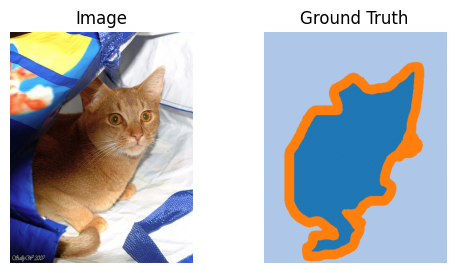

In [7]:
vtk.visualize_datapoint(ex_img, ex_mask - 1)

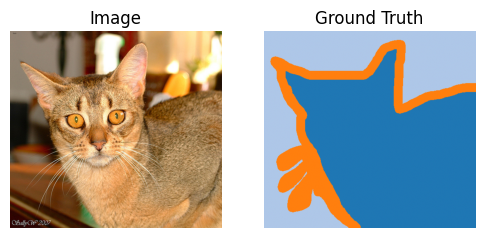

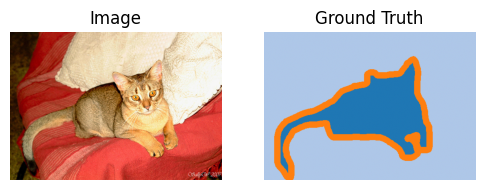

In [8]:
for i in range(1, 4):
    vtk.visualize_datapoint(
        np.array(dataset_raw[i][0]),
        np.array(dataset_raw[i][1]) - 1
    )

Observăm următoarele:
- clasa 1 este asociata animăluțului
- clasa 2 este asociata fundalului
- clasa 3 este asociata conturului

Dorim să segmentăm doar animăluțul, deci o strategie ar fi să considerăm toți pixelii contur ca făcând parte din animăluț.

Mai observam că imaginile au diferite dimensiuni. În general, pentru a facilita antrenamentul pe mai multe date în paralel, este necesar să avem o dimensiune comună a datelor. O soluție pentru a avea aceeași dimensiune a imaginilor este să aplicăm câteva transformări, precum central crop și redimensionare, atât pe imaginile date, cât și pe măștile de segmentare.

Alte transformări pe care le vom aplica sunt scalarea datelor pe un anumit interval (normalizarea datelor) pentru operații numerice mai eficiente.

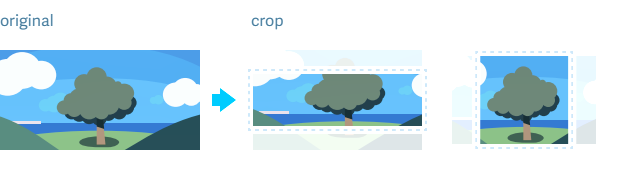

In [9]:
image_size = 64

def center_crop(img: Image):
    """
    Performs a center crop on the input image based on the minimum dimension.
    """
    return transforms.CenterCrop(min(img.width, img.height))(img)

img_transform = transforms.Compose([
    center_crop,
    transforms.Resize(
        image_size, interpolation=transforms.InterpolationMode.BILINEAR
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)), # [0, 1] -> [-1, 1]
])

def process_mask(mask: Image):
    """
    Maps the classes of the mask.
    """
    np_mask = np.array(mask)

    # transformam clasele in 0 ptr background, 1 ptr animalut
    np_mask[np_mask == 1] = 1 # animalut
    np_mask[np_mask == 2] = 0 # background
    np_mask[np_mask == 3] = 1 # contur -> animalut

    torch_mask = torch.tensor(np_mask).float()
    return torch_mask.unsqueeze(0) # (H, W) -> (1, H, W)


target_transform = transforms.Compose([
    center_crop,
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.NEAREST),
    process_mask,
])

dataset = torchvision.datasets.OxfordIIITPet(
    root="./",
    target_types="segmentation",
    split='trainval',
    download=True,
    transform=img_transform,
    target_transform=target_transform
)
print("Lungime dataset:", len(dataset))

Lungime dataset: 3680


In [10]:
ex_item = dataset[0]
print("Exemplu imagine:", ex_item[0])
print("Exemplu masca:", ex_item[1])

Exemplu imagine: tensor([[[-0.5451, -0.5373, -0.5216,  ...,  0.9059,  0.9216,  0.9216],
         [-0.4667, -0.5608, -0.5765,  ...,  0.9294,  0.9137,  0.9216],
         [ 0.4118, -0.3569, -0.4980,  ...,  0.9216,  0.8980,  0.9137],
         ...,
         [-0.7725, -0.7647, -0.7490,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7882, -0.7804, -0.7647,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8039, -0.8039, -0.7882,  ...,  1.0000,  1.0000,  1.0000]],

        [[-0.1765, -0.1529, -0.1294,  ...,  0.9059,  0.9137,  0.9137],
         [-0.2314, -0.2471, -0.2941,  ...,  0.9216,  0.9059,  0.9059],
         [ 0.0902,  0.1451, -0.0118,  ...,  0.9137,  0.8980,  0.9059],
         ...,
         [-0.7569, -0.7333, -0.7098,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7725, -0.7647, -0.7333,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7961, -0.7882, -0.7725,  ...,  1.0000,  1.0000,  1.0000]],

        [[ 0.7725,  0.7804,  0.8039,  ...,  0.9451,  0.9529,  0.9529],
         [ 0.6392,  0.7020, 

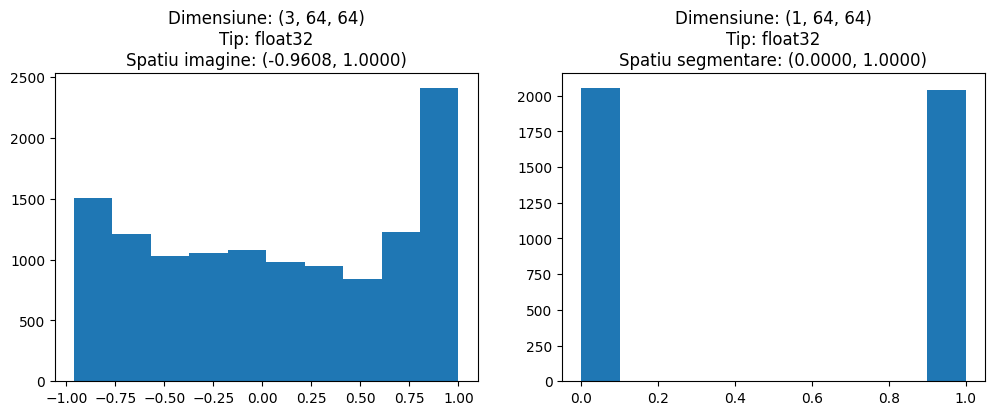

In [11]:
ex_img = ex_item[0].numpy()
ex_mask = ex_item[1].numpy()

vtk.compute_stats(ex_img, ex_mask)

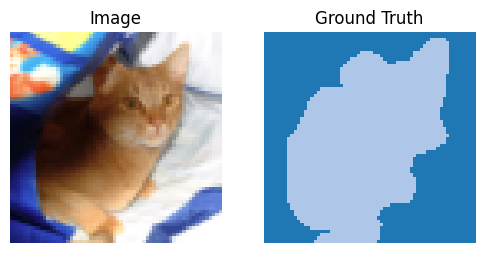

In [12]:
def postprocess_img(img: np.ndarray):
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)) # (3, H, W) -> (H, W, 3)
    return img

def postprocess_mask(mask: np.ndarray):
    threshold = 0.5
    mask = np.array(mask > threshold, dtype=np.int32)
    return mask.squeeze()

vtk.visualize_datapoint(
    postprocess_img(ex_img),
    postprocess_mask(ex_mask)
)

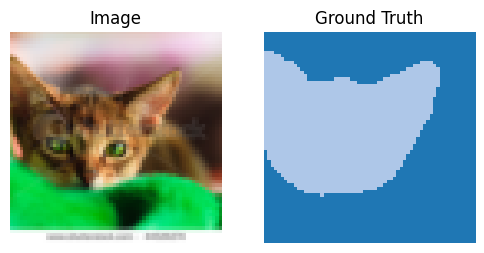

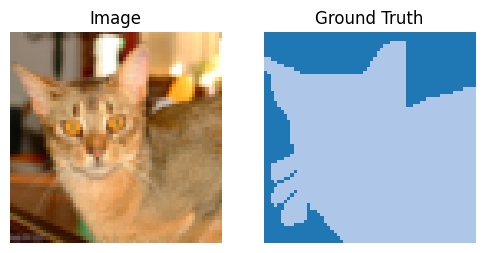

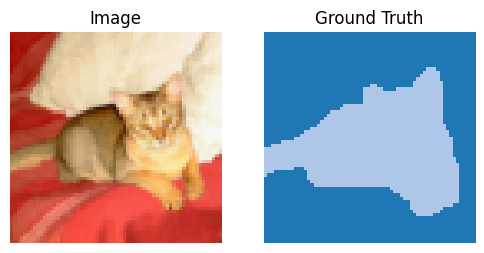

In [13]:
for i in range(1, 4):
    vtk.visualize_datapoint(
        postprocess_img(dataset[i][0].numpy()),
        postprocess_mask(dataset[i][1].numpy())
    )

### *Cât de bună este masca de segmentare?* - Metrici de evaluare

#### Intersection over Union (IoU):** (cunoscut și ca Jaccard Index)
  - Măsoară suprapunerea dintre segmentarea prevăzută și realitate.
  - Valori in intervalul [0, 1].
  - O segmentare perfectă înseamnă IoU = 1.0 (suprapunere 100%).
  - Formulă:
$$
\text{IoU} = \frac{TP}{TP + FP + FN}
$$
    * TP (True Positives): pixeli prezisi corect ca foreground (prim-plan).
    * FP (False Positives): pixeli de fundal prezisi în mod eronat ca fiind foreground.
    * FN (False Negatives): pixeli din foreground omisi (prezisi ca fundal).
    * TN (True Negative): pixeli prezisi corect ca fundal.

<img src="https://framerusercontent.com/images/Dzpkrkzlq8W4pwHnfcoukNZNM.webp?width=1300&height=952" width="50%" />
<img src="https://framerusercontent.com/images/sbZ3R92a503xZEedfPFEhgpxs.webp?width=1300&height=668" width="50%" />

*[image source]([[source=https://www.v7labs.com/blog/image-segmentation-guide]])*

In [14]:
def compute_miou(preds: np.ndarray, masks: np.ndarray):
    iou_values_per_class = []

    for cls in np.unique(masks): # pentru fiecare clasa din masca - animalut si background
        predicted_cls = preds == cls # returneaza un array cu acelasi shape cu True pentru valorile egale, False pentru cele inegale
        mask_cls = masks == cls # la fel ca mai sus
        intersection = (predicted_cls & mask_cls).sum() # elementele care sunt egale cu clasa si in predictie, si in ground truth
        union = (predicted_cls | mask_cls).sum() # elementele care sunt egale cu clasa fie in predictie, fie in ground truth
        iou = intersection / union
        iou_values_per_class.append(iou)

    return np.mean(iou_values_per_class) # calculam media aritmetica pentru fiecare clasa

- **Dice Similarity Coefficient (DSC):**
  - Măsoară similitudinea dintre două seturi (predicție și realitate), favorizând suprapunerea.
  - Similar cu IoU, dar acordă mai multă importanță zonelor de suprapunere.
  - Valori in intervalul [0, 1].
  - Formulă:
$$
\text{DSC} = \frac{2TP}{2TP + FP + FN}
$$

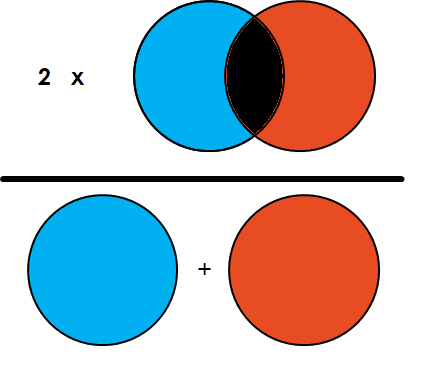

Sursa: [kaggle](https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient)

In [15]:
def compute_dice(preds: np.ndarray, masks: np.ndarray):
    dice_values_per_class = []

    for cls in np.unique(masks):
        predicted_cls = preds == cls
        mask_cls = masks == cls
        intersection = (predicted_cls & mask_cls).sum()
        dice = 2 * intersection / (predicted_cls.sum() + mask_cls.sum())
        dice_values_per_class.append(dice)

    return np.mean(dice_values_per_class)

- **Pixel Accuracy (PA):**
  - Măsoară procentul de pixeli clasificați corect din totalul pixelilor.
  - Valori in intervalul [0, 1].
  - Poate fi înșelător dacă fundalul domină imaginea (de exemplu, 95% fundal → PA ridicat chiar și cu segmentare slabă).
  - Formulă:
$$
PA = \frac{TP + TN}{TP + TN + FP + FN}
$$
  - **Hint**: Pixelii clasificați corect (adică intersecția) supra numărul total de pixeli.

In [16]:
def compute_pixel_acc(preds: np.ndarray, masks: np.ndarray):
    #TODO Folosind formula de mai sus, implementati o metodă pentru calculare PA
    return 0

### Metrici de Validare

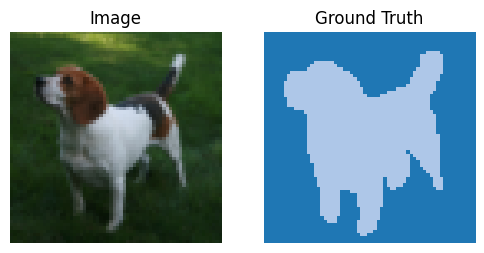

In [17]:
def shift_mask_right(mask: np.ndarray, shift: int = 1):
    # Deplasează toate elementele unei măști 2D spre dreapta cu un număr dat de pixeli.
    result = np.zeros_like(mask)
    if shift < mask.shape[1]:
        result[:, shift:] = mask[:, :-shift]
    return result

def random_mask_bit_flip(mask: np.ndarray, ratio: float):
    # Inversează aleatoriu un raport dat de biți (0 <-> 1) în mască — simulând zgomotul sau corupția.
    num_pixels = mask.size
    num_flips = int(num_pixels * ratio)
    indices = np.random.choice(num_pixels, num_flips, replace=False)

    flat = mask.flatten()
    flat[indices] = 1 - flat[indices]
    flipped_map = flat.reshape(mask.shape)
    return flipped_map

def print_metrics(gt_mask: np.ndarray, pred_mask: np.ndarray):
    print(f"MIoU: {compute_miou(gt_mask, pred_mask)}")
    print(f"Dice: {compute_dice(gt_mask, pred_mask)}")
    print(f"Pixel Accuracy: {compute_pixel_acc(gt_mask, pred_mask)}")

ex_img, ex_mask = dataset[222]
ex_img = postprocess_img(ex_img.numpy())
ex_mask = postprocess_mask(ex_mask.numpy())
vtk.visualize_datapoint(ex_img, ex_mask)

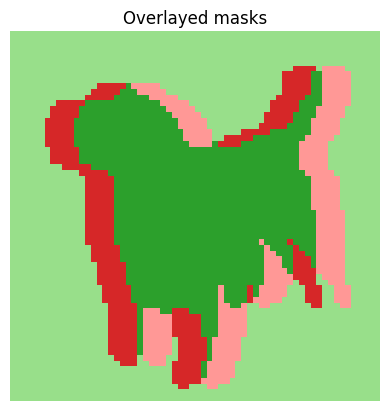

MIoU: 0.6495435856214039
Dice: 0.7849060770027432
Pixel Accuracy: None


In [18]:
err_mask_1 = shift_mask_right(ex_mask, 5)
vtk.plot_overlayed_mask(ex_mask, err_mask_1)
print_metrics(ex_mask, err_mask_1)

#### Notiță:
- verde închis sunt pixelii corect clasificați ca animăluț (TP ptr clasa animăluț)
- verde deschis sunt pixelii corect clasificați ca fundal (TN ptr clasa animăluț)
- roșu deschis sunt pixelii greșit clasificați ca animăluț (FP ptr clasa animăluț)
- roșu închis sunt pixelii greșit clasificați ca fundal (FN ptr clasa animăluț)

#### MiOU

$$
MIoU \text{(pentru clasa animalut)} = \frac{\texttt{num\_pixels}(\text{verde inchis})}{\texttt{num\_pixels}(\text{verde inchis}) + \texttt{num\_pixels}(\text{rosu})}
$$

### Dice

$$
Dice \text{(pentru clasa animalut)} = \frac{2 \cdot \texttt{num\_pixels}(\text{verde inchis})}{\texttt{num\_pixels}(\text{rosu}) + 2 \cdot \texttt{num\_pixels}(\text{verde inchis})}
$$

### Pixel Accuracy
$$
Pixel Acc = \frac{\texttt{num\_pixels}(\text{verde})}{\texttt{num\_pixels}(\text{verde}) + \texttt{num\_pixels}(\text{rosu})}
$$

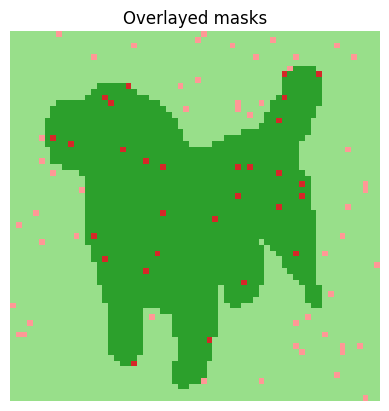

MIoU: 0.9585734415130268
Dice: 0.9788194615349111
Pixel Accuracy: None


In [19]:
err_mask_2 = random_mask_bit_flip(ex_mask, 0.02)
vtk.plot_overlayed_mask(ex_mask, err_mask_2)
print_metrics(ex_mask, err_mask_2)

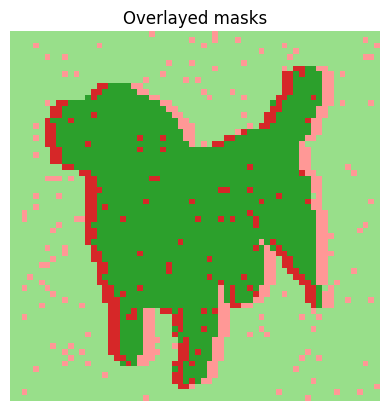

MIoU: 0.7643060641053835
Dice: 0.8654511325875758
Pixel Accuracy: None


In [20]:
err_mask_3 = shift_mask_right(random_mask_bit_flip(ex_mask, 0.05), 2)
vtk.plot_overlayed_mask(ex_mask, err_mask_3)
print_metrics(ex_mask, err_mask_3)

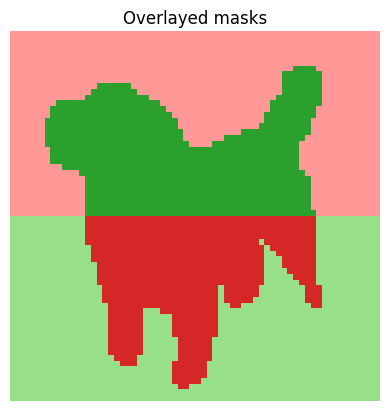

MIoU: 0.35269832347400065
Dice: 0.5187663749465857
Pixel Accuracy: None


In [21]:
err_mask_4 = np.zeros_like(ex_mask)
err_mask_4[:err_mask_4.shape[0] // 2] = 1
vtk.plot_overlayed_mask(ex_mask, err_mask_4)
print_metrics(ex_mask, err_mask_4)

## Antrenarea unui model

### Împărțirea dataset-ului

Pentru a putea validă că modelul nostru nu este *"overfitted"* pe setul de date, vom împărți datele în 2 submulțimi:
- setul de antrenament *(train_dataset)*: această submulțime este folosită de model pentru a învăța să rezolve problema de segmentare a imaginilor.
- setul de validare *(val_dataset)*: această submulțime este folosită pentru a valida performanța modelului în timpul antrenării, date pe care modelul nu le va folosi în etapa de învățare.
- setul de testare *(test_dataset)*: această submulțime este folosită pentru a testa performanța modelului după finalizarea antrenamentului.

In [22]:
train_len = int(0.76 * len(dataset))
val_len = int(0.18 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])
print("Lungime train:", len(train_dataset))
print("Lungime validation:", len(val_dataset))
print("Lungime test:", len(test_dataset))

Lungime train: 2796
Lungime validation: 662
Lungime test: 222


### Dataloader

Mometan datele noastre se află într-o structura de tip *Dataset*. Pentru a putea antrena date în batch-uri ([mini-batch training](https://www.geeksforgeeks.org/deep-learning/mini-batch-gradient-descent-in-deep-learning/)) și pentru a avea datele într-o ordine aleatoare, PyTorch ne oferă la dispoziție clasa **_DataLoader_** pentru a ajusta acești parametrii.

In [23]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Lungime train loader:", len(train_loader))
print("Lungime validation loader:", len(val_loader))
print("Lungime test loader:", len(test_loader))

Lungime train loader: 44
Lungime validation loader: 11
Lungime test loader: 4


In [24]:
for item in train_loader:
    print(item[0].shape)
    print(item[1].shape)
    break


torch.Size([64, 3, 64, 64])
torch.Size([64, 1, 64, 64])


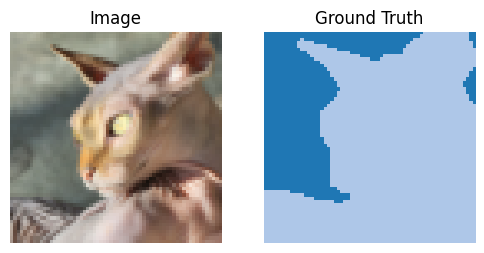

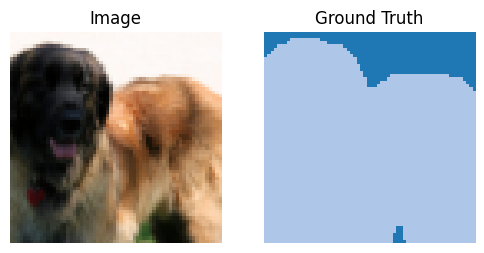

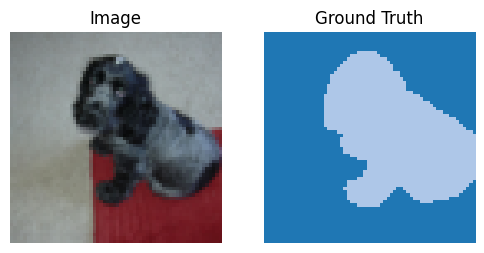

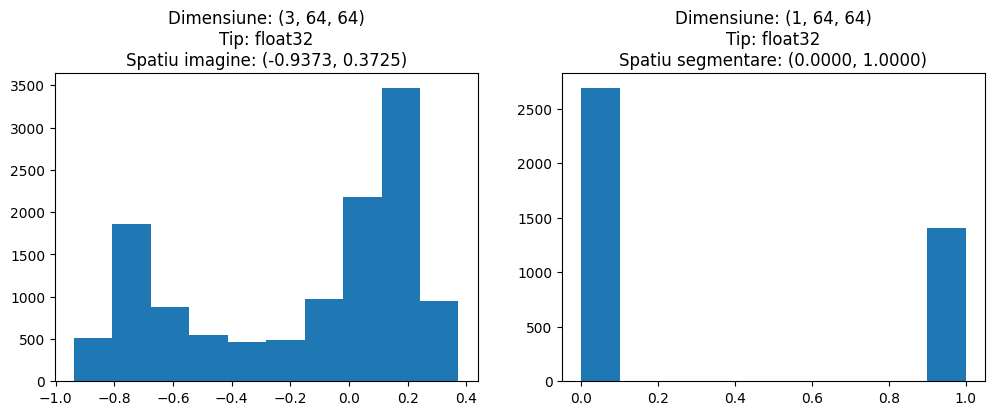

In [25]:
for (images, masks) in train_loader:
    for idx in range(4):
        ex_img = images[idx].numpy()
        ex_mask = masks[idx].numpy()
        vtk.visualize_datapoint(
            postprocess_img(ex_img), postprocess_mask(ex_mask)
        )
    vtk.compute_stats(ex_img, ex_mask)
    break

## Antrenament

In [86]:
class SegmentationTrainer:
    def __init__(
        self,
        model: nn.Module,
        optimizer: optim.Optimizer,
        log_iterations: dict[str, int],
        device: torch.device = torch.device("cpu"),
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_criterion = nn.BCELoss()
        self.log_iterations = log_iterations
        self.device = device
        self.stats = {
            "train": {"miou": [], "dice": [], "pixel_acc": [], "loss": []},
            "val": {"miou": [], "dice": [], "pixel_acc": [], "loss": []},
        }

    def train_batch(self, images: torch.Tensor, masks: torch.Tensor):
        images = images.to(self.device)
        masks = masks.to(self.device)

        self.optimizer.zero_grad() # reset the optimizer
        preds = self.model(images) # forward propagation - set the gradients
        loss = self.loss_criterion(preds, masks)

        loss.backward() # backpropagation - compute the steps towards the better weights based on the loss and the gradients
        self.optimizer.step() # update the weights

        return preds.detach().cpu(), loss.item()

    def validate_batch(self, images: torch.Tensor, masks: torch.Tensor):
        images = images.to(self.device)
        masks = masks.to(self.device)

        preds = self.model(images) # forward propagation - the gradients are not set because @torch.no_grad()
        loss = self.loss_criterion(preds, masks)

        return preds.detach().cpu(), loss.item()

    def log_metrics(
        self,
        iteration: int,
        epoch: int,
        split: str, # "train" | "val"
        images: np.ndarray,
        masks: np.ndarray,
        preds: np.ndarray,
        loss: float,
    ):
        preds = preds > 0.5 # apply some threshold, why is this useful?
        miou = compute_miou(preds.numpy(), masks.numpy())
        dice = compute_dice(preds.numpy(), masks.numpy())
        pixel_acc = compute_pixel_acc(preds.numpy(), masks.numpy())

        self.stats[split]["miou"].append(miou)
        self.stats[split]["dice"].append(dice)
        self.stats[split]["pixel_acc"].append(pixel_acc)
        self.stats[split]["loss"].append(loss)

        if (iteration + 1) % self.log_iterations[split] == 0 or iteration == 0:
            print(
                f"{split} epoch: {epoch+1} - iteration {iteration+1}:"
                f"\n - miou: {np.mean(self.stats[split]['miou'][-10:]):.6f}"
                f"\n - dice: {np.mean(self.stats[split]['dice'][-10:]):.6f}"
                f"\n - pixel accuracy: {np.mean(self.stats[split]['pixel_acc'][-10:]):.6f}"
                f"\n - loss: {np.mean(self.stats[split]['loss'][-10:]):.6f}"
            )
            viz_image = postprocess_img(images[2].numpy())
            viz_mask = postprocess_mask(masks[2].numpy())
            viz_output = postprocess_mask(preds[2].numpy())
            vtk.visualize_datapoint(viz_image, viz_mask, viz_output)

    def train_loader(self, train_loader: DataLoader, epoch: int):
        self.model.train()
        for idx, (images, masks) in enumerate(train_loader):
            preds, loss = self.train_batch(images, masks)
            self.log_metrics(idx, epoch, "train", images, masks, preds, loss)

    @torch.no_grad()
    def validate_loader(self, val_loader: DataLoader, epoch: int):
        self.model.eval()
        for idx, (images, masks) in enumerate(val_loader):
            preds, loss = self.validate_batch(images, masks)
            self.log_metrics(idx, epoch, "val", images, masks, preds, loss)

## Modele de Deep Learning
### Rețele neuronale convoluționale

Stratul de convoluție este principalul bloc de construcție al unei rețele neuronale convoluționale. Aceste straturi conțin un set de filtre care pot fi învățate, iar acestea vor învăța ce caracteristici sunt relevante pentru problema de clasificare, pe baza datelor de antrenament.

În timpul procesului de propagare înainte (forward pass), fiecare filtru (care trebuie să aibă aceeași adâncime ca și volumul de intrare) este deplasat peste dimensiunile spațiale ale volumului de intrare, iar pentru fiecare poziție se calculează o înmulțire element cu element între valorile filtrului și regiunea de interes din volumul de intrare care se află sub filtru.

Hiperparametrii unui strat de convoluție sunt:

- dimensiunea filtrului `F` (de obicei aceasta este o valoare impară);
- cantitatea de padding adăugată volumului de intrare `P`;
- pasul de deplasare (sau stride) `S`, utilizat la glisarea peste volumul de intrare;
- numărul de filtre `k`; adâncimea fiecărui filtru trebuie să corespundă adâncimii volumului de intrare.

<img src="https://lh6.googleusercontent.com/gZxwFH6mQ5tPjz6LzVbOaNeVuR1NC-BnuemIWO41qnn7r1PvP4qzwXRWC1OJgo2_PD08qaqJ2-VCF3q9laeK885IJwK-dHhpLDkvRZrx4vxrbLDTsKD2iZYM5SFRq4A6XTklk7_h" width="60%" />

## Arhitectura: Encoder-Decoder

Arhitectura Encoder–Decoder este un model general și versatil folosit în multe domenii ale învățării profunde — de la procesarea limbajului natural la vizualizarea computerizată și generarea de imagini.

Cum funcționează?

- Encoderul (codificatorul) transformă datele de intrare (imagine, text, semnal etc.) într-o reprezentare latentă compactă, captând informațiile esențiale și structura semantică.

- Decoderul (decodificatorul) pornește de la această reprezentare internă și reconstruiește ieșirea dorită, cum ar fi o propoziție tradusă, o imagine reconstruită sau o mască de segmentare.

- În unele variante, se pot adăuga mecanisme de atenție (attention) pentru a permite decodorului să se concentreze selectiv pe părți relevante din ieșirea encoderului, îmbunătățind calitatea și precizia rezultatelor - nu ne vom concentra pe asta, la la.

<img src="https://framerusercontent.com/images/5OAi3pfUU5JHB5IpKuEEaDpsehc.png?width=1240&height=752" width="50%" />

In [92]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class UpscaleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor):
        x = F.interpolate(x, (x.shape[-2] * 2, x.shape[-1] * 2), mode='bilinear')
        x = self.conv(x)
        x = self.relu(x)
        return x

class EncoderDecoder(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, scale: int = 32):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, scale)
        self.enc2 = DoubleConv(scale, scale * 2)
        self.enc3 = DoubleConv(scale * 2, scale * 4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up2 = UpscaleConv(scale * 4, scale * 2)
        self.dec2 = DoubleConv(scale * 2, scale * 2)

        self.up1 = UpscaleConv(scale * 2, scale)
        self.dec1 = DoubleConv(scale, scale)

        self.final = nn.Conv2d(scale, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        # Encoder
        e1 = self.enc1(x)
        
        e2 = self.pool(e1)
        e2 = self.enc2(e2)
        
        e3 = self.pool(e2)
        e3 = self.enc3(e3)

        # Decoder
        d2 = self.up2(e3)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = self.dec1(d1)

        # Final layers
        x = self.final(d1)
        x = self.sigmoid(x)
        return x

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EncoderDecoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

print("Device:", device)

Device: cuda


train epoch: 1 - iteration 1:
 - miou: 0.331497
 - dice: 0.494030
 - loss: 0.710151


train epoch: 1 - iteration 22:
 - miou: 0.391757
 - dice: 0.558319
 - loss: 0.672614


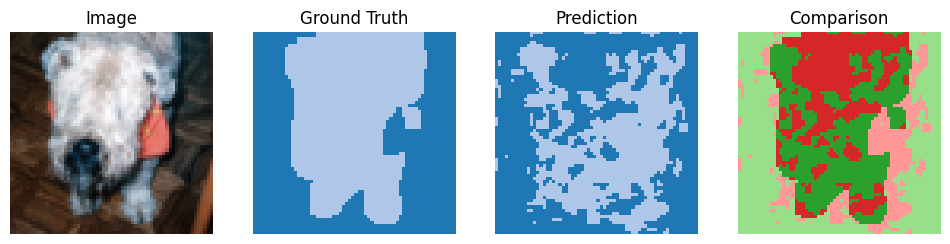

train epoch: 1 - iteration 44:
 - miou: 0.458411
 - dice: 0.627202
 - loss: 0.642941


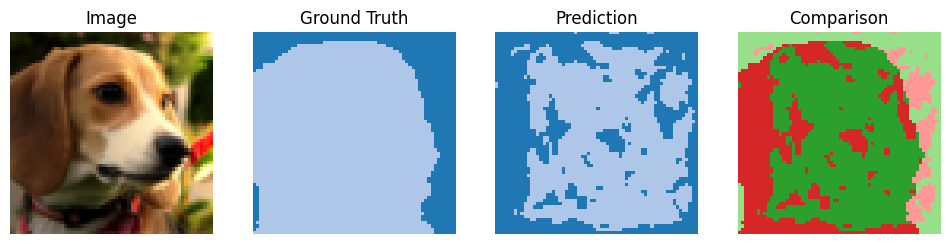

val epoch: 1 - iteration 1:
 - miou: 0.286397
 - dice: 0.404634
 - loss: 0.672513


val epoch: 1 - iteration 11:
 - miou: 0.297478
 - dice: 0.417173
 - loss: 0.671135


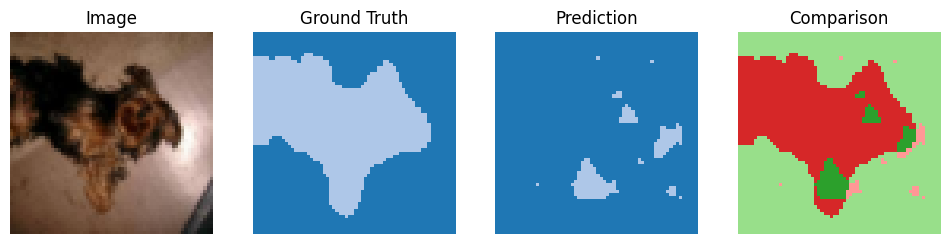

train epoch: 2 - iteration 1:
 - miou: 0.460328
 - dice: 0.629209
 - loss: 0.642706


train epoch: 2 - iteration 22:
 - miou: 0.524904
 - dice: 0.688283
 - loss: 0.610769


train epoch: 2 - iteration 44:
 - miou: 0.554389
 - dice: 0.713031
 - loss: 0.591897


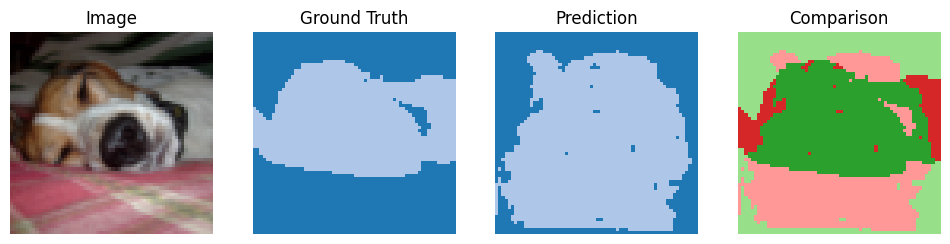

val epoch: 2 - iteration 1:
 - miou: 0.325359
 - dice: 0.448621
 - loss: 0.661770


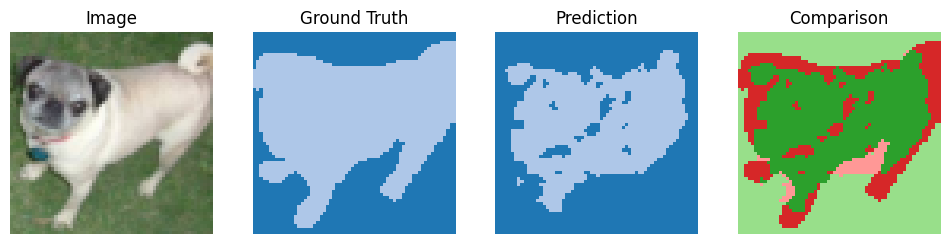

val epoch: 2 - iteration 11:
 - miou: 0.568302
 - dice: 0.724453
 - loss: 0.578865


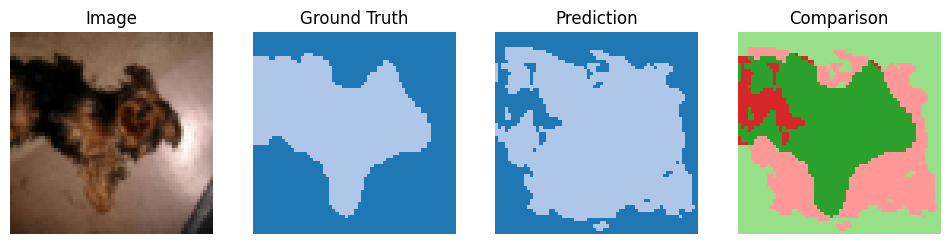

train epoch: 3 - iteration 1:
 - miou: 0.559064
 - dice: 0.716875
 - loss: 0.588285


train epoch: 3 - iteration 22:
 - miou: 0.584498
 - dice: 0.737488
 - loss: 0.563542


train epoch: 3 - iteration 44:
 - miou: 0.605920
 - dice: 0.754533
 - loss: 0.537389


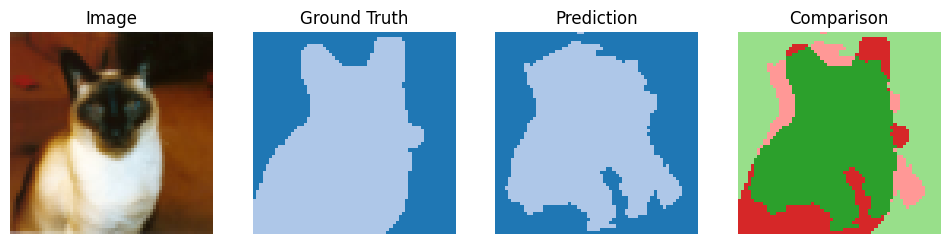

val epoch: 3 - iteration 1:
 - miou: 0.570556
 - dice: 0.726210
 - loss: 0.574927


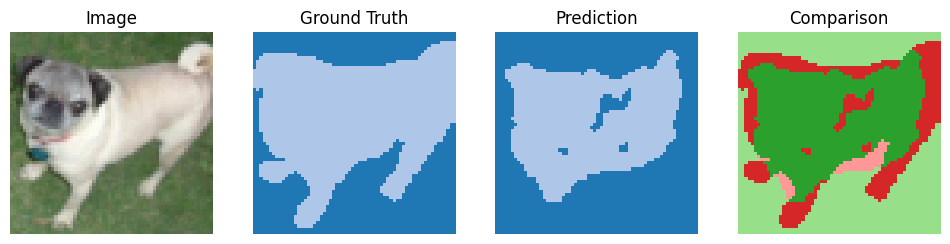

val epoch: 3 - iteration 11:
 - miou: 0.597490
 - dice: 0.747684
 - loss: 0.537959


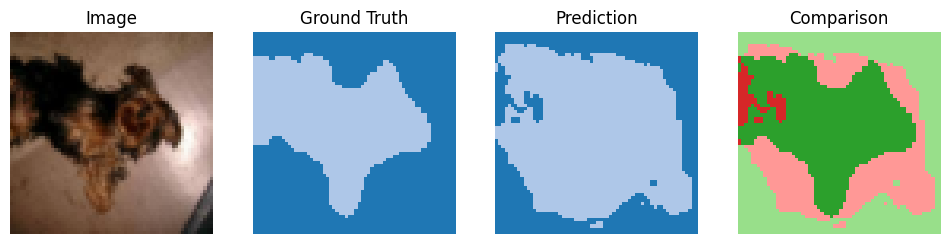

train epoch: 4 - iteration 1:
 - miou: 0.609758
 - dice: 0.757510
 - loss: 0.535026


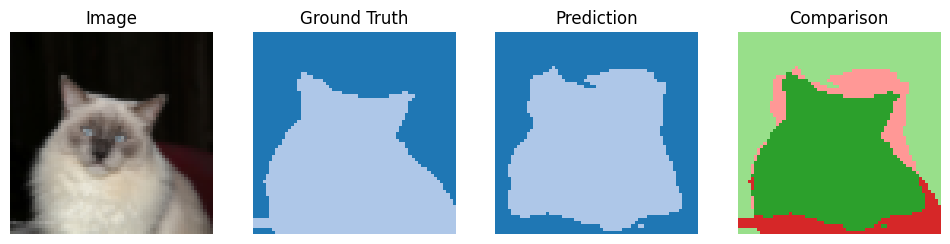

train epoch: 4 - iteration 22:
 - miou: 0.607527
 - dice: 0.755785
 - loss: 0.528397


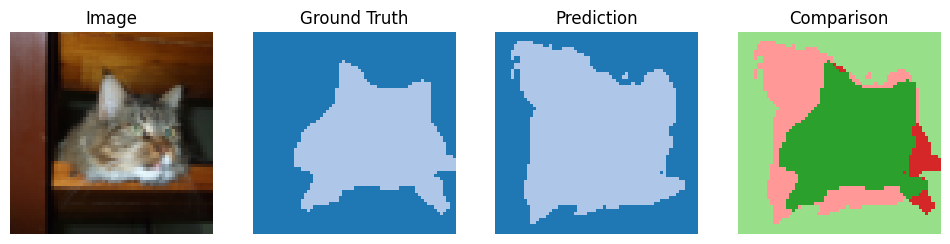

train epoch: 4 - iteration 44:
 - miou: 0.617416
 - dice: 0.763396
 - loss: 0.516489


val epoch: 4 - iteration 1:
 - miou: 0.598796
 - dice: 0.748682
 - loss: 0.536290


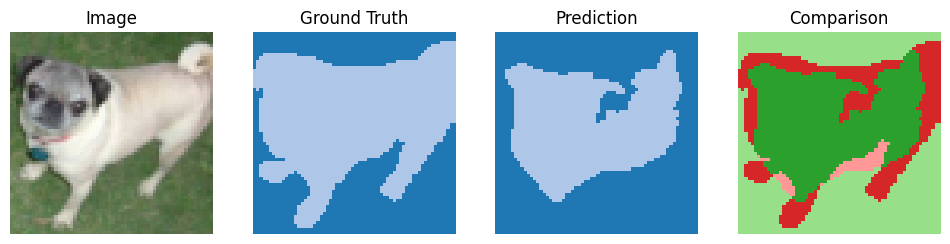

val epoch: 4 - iteration 11:
 - miou: 0.615076
 - dice: 0.761383
 - loss: 0.514391


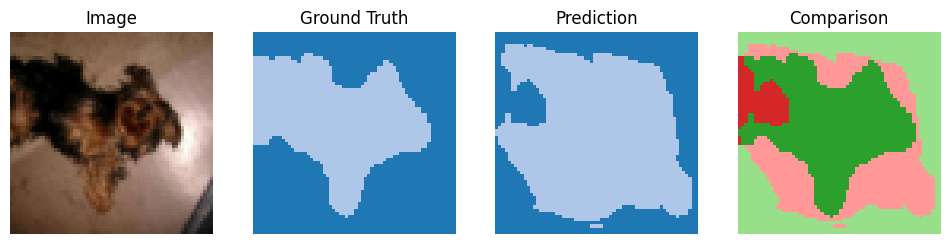

train epoch: 5 - iteration 1:
 - miou: 0.620057
 - dice: 0.765402
 - loss: 0.514216


train epoch: 5 - iteration 22:
 - miou: 0.621848
 - dice: 0.766697
 - loss: 0.508649


train epoch: 5 - iteration 44:
 - miou: 0.628483
 - dice: 0.771792
 - loss: 0.499306


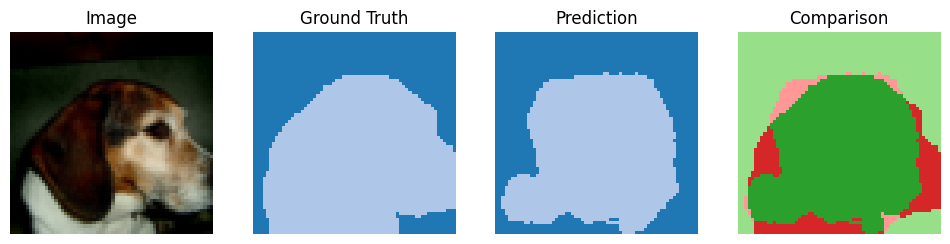

val epoch: 5 - iteration 1:
 - miou: 0.615604
 - dice: 0.761780
 - loss: 0.513677


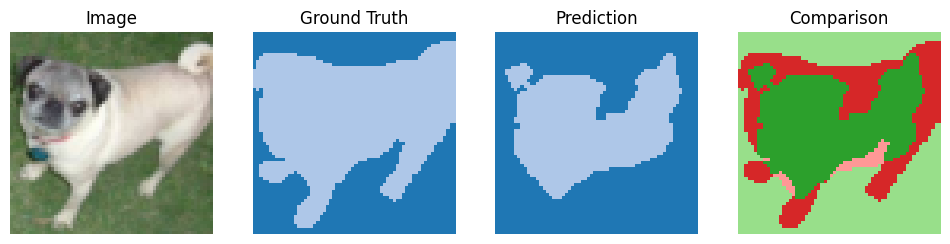

val epoch: 5 - iteration 11:
 - miou: 0.623750
 - dice: 0.768042
 - loss: 0.503316


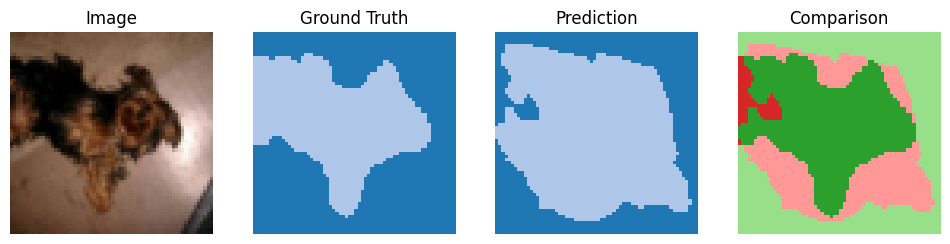

train epoch: 6 - iteration 1:
 - miou: 0.631281
 - dice: 0.773878
 - loss: 0.496907


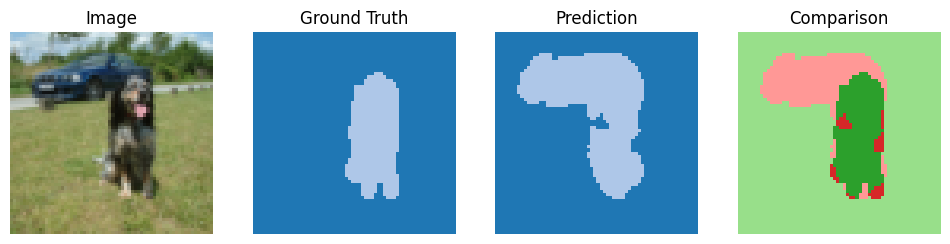

train epoch: 6 - iteration 22:
 - miou: 0.638585
 - dice: 0.779346
 - loss: 0.489512


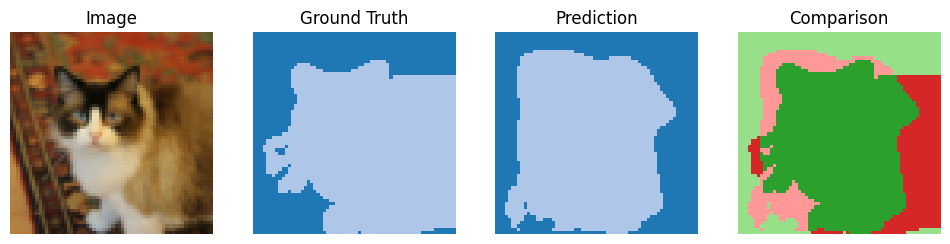

train epoch: 6 - iteration 44:
 - miou: 0.646630
 - dice: 0.785244
 - loss: 0.480773


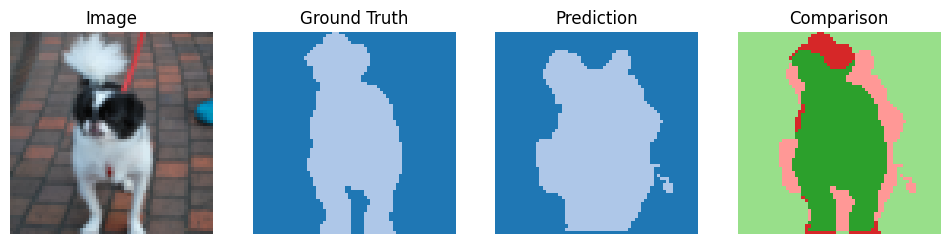

val epoch: 6 - iteration 1:
 - miou: 0.624802
 - dice: 0.768833
 - loss: 0.502600


val epoch: 6 - iteration 11:
 - miou: 0.631238
 - dice: 0.773699
 - loss: 0.493301


train epoch: 7 - iteration 1:
 - miou: 0.645904
 - dice: 0.784697
 - loss: 0.480231


train epoch: 7 - iteration 22:
 - miou: 0.650580
 - dice: 0.788265
 - loss: 0.472825


train epoch: 7 - iteration 44:
 - miou: 0.648238
 - dice: 0.786475
 - loss: 0.471002


val epoch: 7 - iteration 1:
 - miou: 0.630776
 - dice: 0.773348
 - loss: 0.493616


val epoch: 7 - iteration 11:
 - miou: 0.624608
 - dice: 0.768502
 - loss: 0.493603


train epoch: 8 - iteration 1:
 - miou: 0.648641
 - dice: 0.786774
 - loss: 0.470258


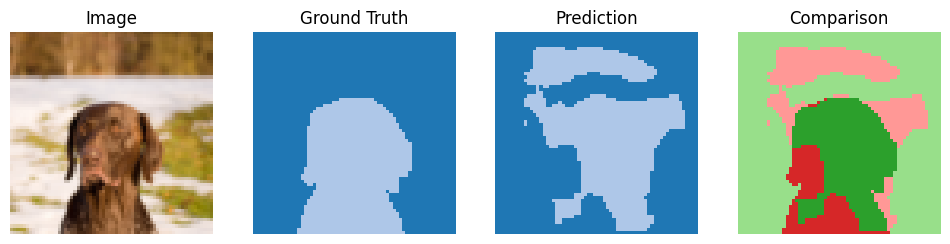

train epoch: 8 - iteration 22:
 - miou: 0.654700
 - dice: 0.791239
 - loss: 0.464514


train epoch: 8 - iteration 44:
 - miou: 0.658442
 - dice: 0.793922
 - loss: 0.459122


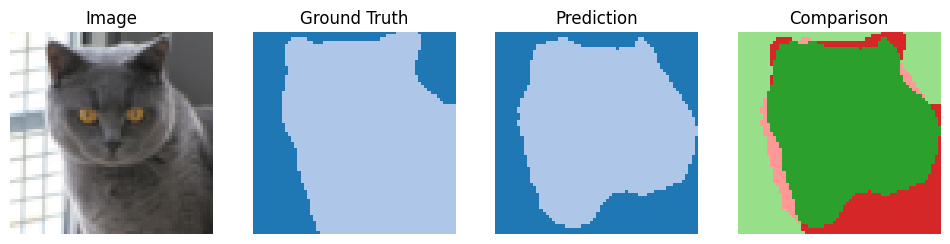

val epoch: 8 - iteration 1:
 - miou: 0.627936
 - dice: 0.771023
 - loss: 0.490844


val epoch: 8 - iteration 11:
 - miou: 0.645002
 - dice: 0.783990
 - loss: 0.471003


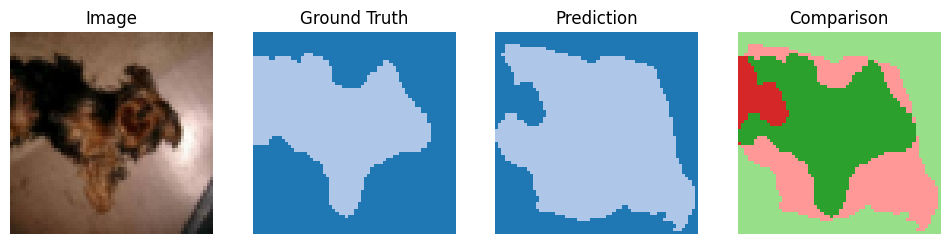

train epoch: 9 - iteration 1:
 - miou: 0.660647
 - dice: 0.795495
 - loss: 0.456686


train epoch: 9 - iteration 22:
 - miou: 0.661887
 - dice: 0.796483
 - loss: 0.454966


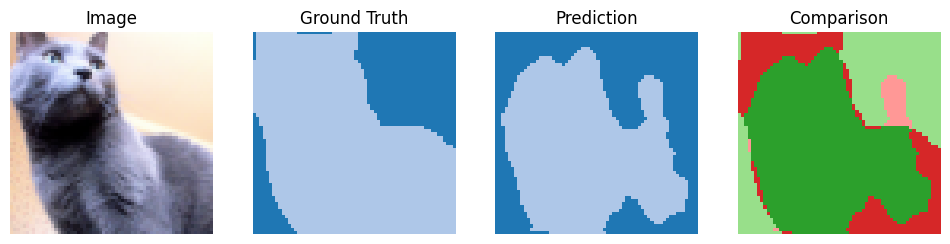

train epoch: 9 - iteration 44:
 - miou: 0.652188
 - dice: 0.789386
 - loss: 0.463163


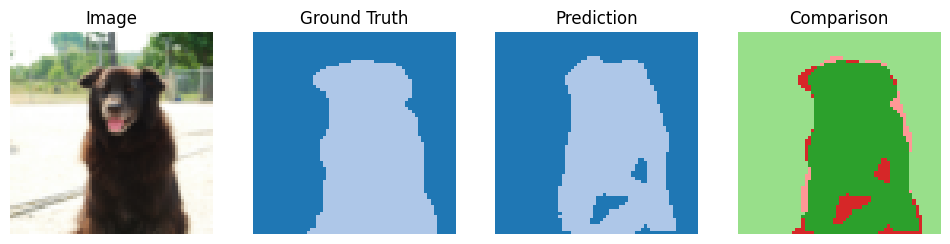

val epoch: 9 - iteration 1:
 - miou: 0.646322
 - dice: 0.784968
 - loss: 0.470374


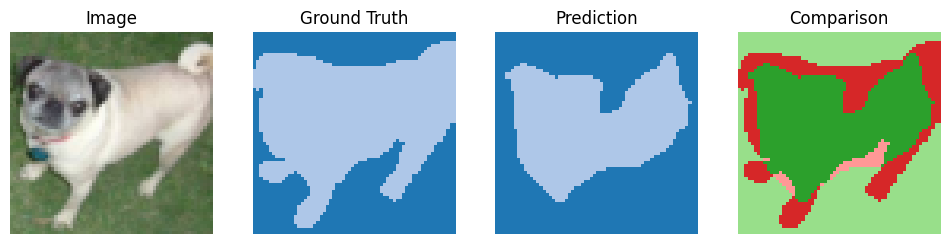

val epoch: 9 - iteration 11:
 - miou: 0.645911
 - dice: 0.784601
 - loss: 0.470266


train epoch: 10 - iteration 1:
 - miou: 0.653738
 - dice: 0.790526
 - loss: 0.460433


train epoch: 10 - iteration 22:
 - miou: 0.659373
 - dice: 0.794529
 - loss: 0.455332


train epoch: 10 - iteration 44:
 - miou: 0.671027
 - dice: 0.802997
 - loss: 0.444104


val epoch: 10 - iteration 1:
 - miou: 0.647963
 - dice: 0.786126
 - loss: 0.468757


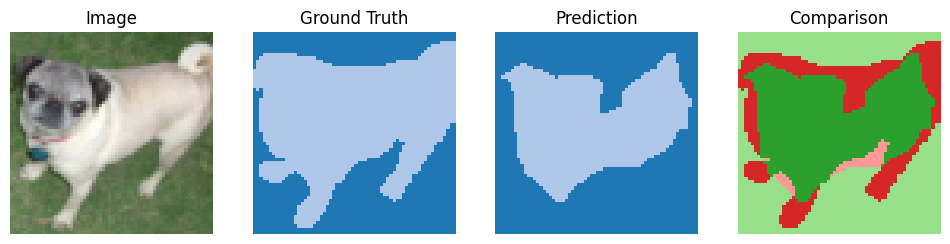

val epoch: 10 - iteration 11:
 - miou: 0.652129
 - dice: 0.789193
 - loss: 0.462190


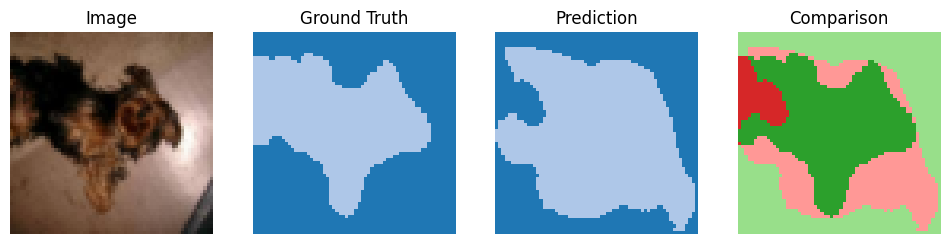

In [94]:
trainer = SegmentationTrainer(model, optimizer, log_iterations={"train": 22, "val": 11}, device=device)

for epoch in range(10):
    trainer.train_loader(train_loader, epoch)
    trainer.validate_loader(val_loader, epoch)

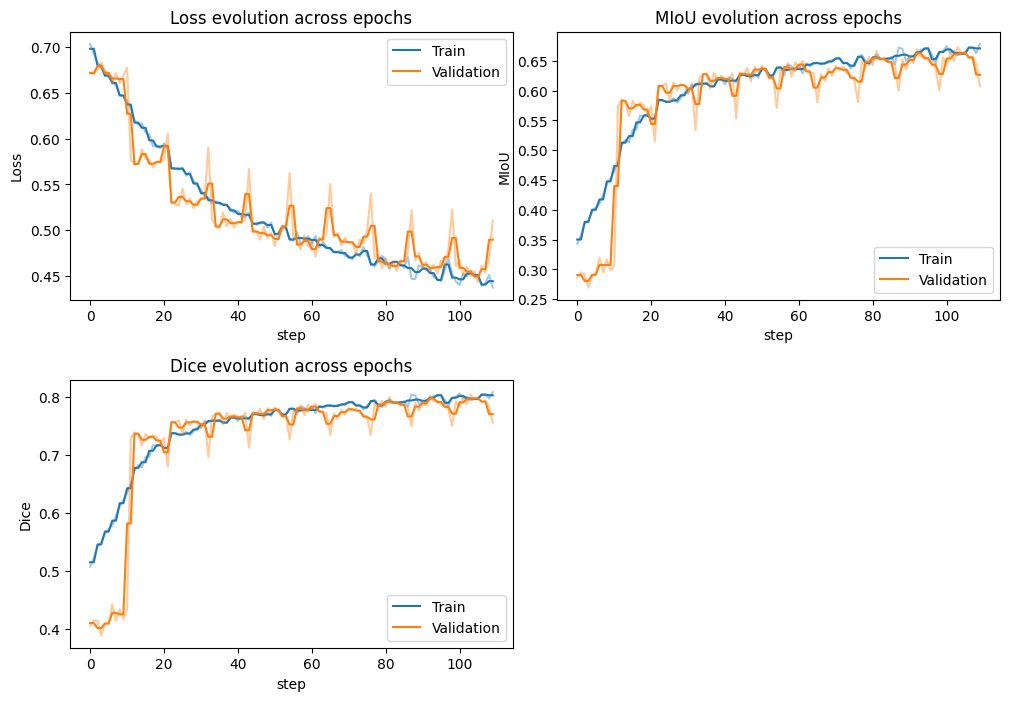

In [96]:
vtk.plot_stats(trainer.stats)

## Arhitectura: U-Net


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="50%" />

Arhitectura **U-Net** este una dintre cele mai elegante și utilizate pe scară largă în domeniul vizualizării computerizate, în special pentru segmentarea imaginilor.

Cum functionează?
* *Codificatorul (encoder)* comprimă imaginea pentru a extrage caracteristici semnificative.
* *Decodificatorul (decoder)* extinde aceste caracteristici la dimensiunea originală pentru a produce o ieșire la nivel de pixel.
* *Conexiunile de salt (skip connections)* ajută la recuperarea detaliilor fine care ar putea fi pierdute în timpul compresiei.

**Fun fact:** Se numește U-Net deoarece arhitectura sa are forma literei "U" când este desenată.

In [97]:
class UNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, scale: int = 64):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, scale)
        self.enc2 = DoubleConv(scale, scale * 2)
        self.enc3 = DoubleConv(scale * 2, scale * 4)
        self.enc4 = DoubleConv(scale * 4, scale * 8)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up3 = UpscaleConv(scale * 8, scale * 4)
        self.dec3 = DoubleConv(scale * 8, scale * 4)
        self.up2 = UpscaleConv(scale * 4, scale * 2)
        self.dec2 = DoubleConv(scale * 4, scale * 2)
        self.up1 = UpscaleConv(scale * 2, scale)
        self.dec1 = DoubleConv(scale * 2, scale)

        self.final = nn.Conv2d(scale, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        # TODO: implementează metoda forward folosind straturile inițializate mai în constructor
        # Hint: torch.cat
        return x
        

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

print("Device:", device)

Device: cuda


train epoch: 1 - iteration 1:
 - miou: 0.324854
 - dice: 0.469227
 - loss: 0.697459


train epoch: 1 - iteration 22:
 - miou: 0.360993
 - dice: 0.516894
 - loss: 0.676354


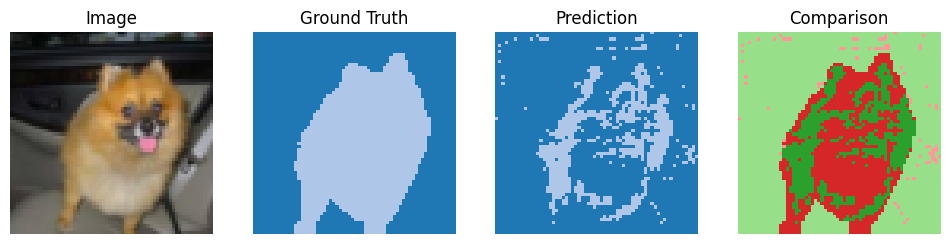

train epoch: 1 - iteration 44:
 - miou: 0.545702
 - dice: 0.704754
 - loss: 0.599735


val epoch: 1 - iteration 1:
 - miou: 0.593619
 - dice: 0.744921
 - loss: 0.590630


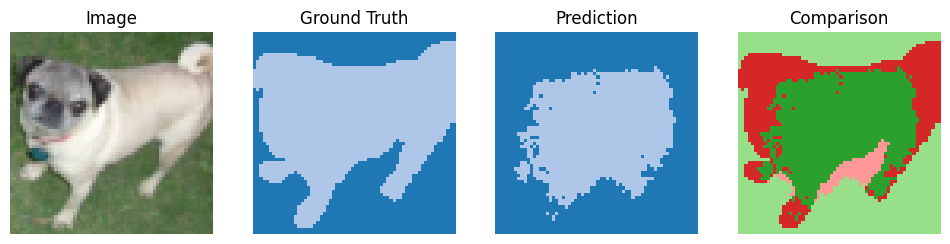

val epoch: 1 - iteration 11:
 - miou: 0.586959
 - dice: 0.739337
 - loss: 0.589336


train epoch: 2 - iteration 1:
 - miou: 0.551813
 - dice: 0.710053
 - loss: 0.597667


train epoch: 2 - iteration 22:
 - miou: 0.622084
 - dice: 0.766679
 - loss: 0.527908


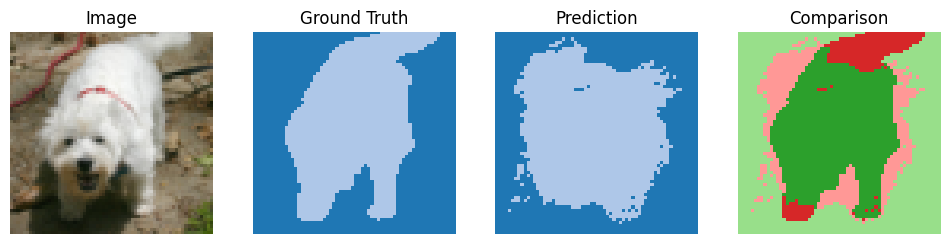

train epoch: 2 - iteration 44:
 - miou: 0.652033
 - dice: 0.789204
 - loss: 0.483619


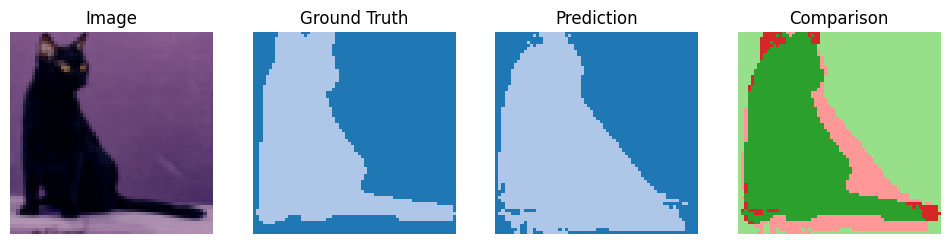

val epoch: 2 - iteration 1:
 - miou: 0.593892
 - dice: 0.744603
 - loss: 0.577222


val epoch: 2 - iteration 11:
 - miou: 0.640334
 - dice: 0.780492
 - loss: 0.478375


train epoch: 3 - iteration 1:
 - miou: 0.654849
 - dice: 0.791227
 - loss: 0.480124


train epoch: 3 - iteration 22:
 - miou: 0.675670
 - dice: 0.806295
 - loss: 0.449763


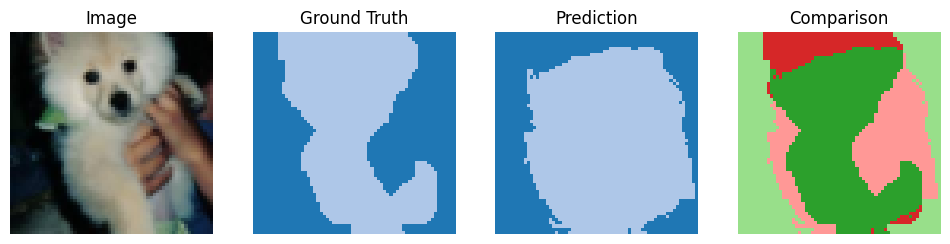

train epoch: 3 - iteration 44:
 - miou: 0.679288
 - dice: 0.808926
 - loss: 0.439246


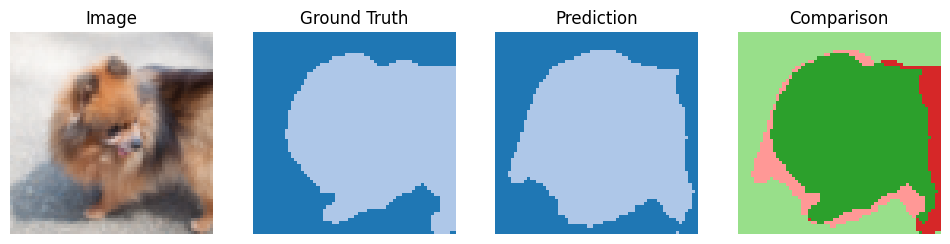

val epoch: 3 - iteration 1:
 - miou: 0.642755
 - dice: 0.782279
 - loss: 0.476293


val epoch: 3 - iteration 11:
 - miou: 0.654528
 - dice: 0.790918
 - loss: 0.460843


train epoch: 4 - iteration 1:
 - miou: 0.679521
 - dice: 0.809091
 - loss: 0.439156


train epoch: 4 - iteration 22:
 - miou: 0.708139
 - dice: 0.829030
 - loss: 0.406294


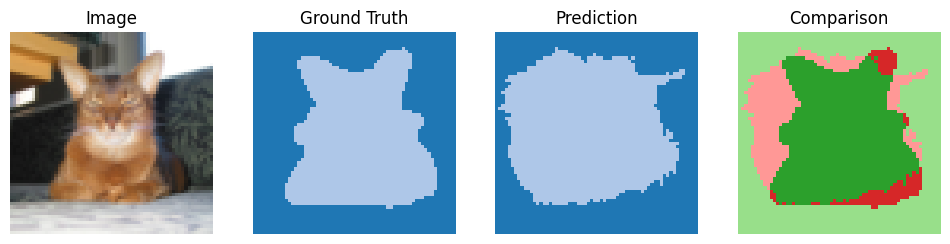

train epoch: 4 - iteration 44:
 - miou: 0.711478
 - dice: 0.831341
 - loss: 0.402433


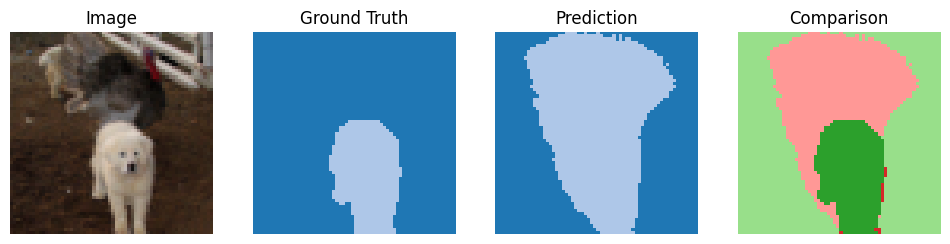

val epoch: 4 - iteration 1:
 - miou: 0.660535
 - dice: 0.795206
 - loss: 0.454629


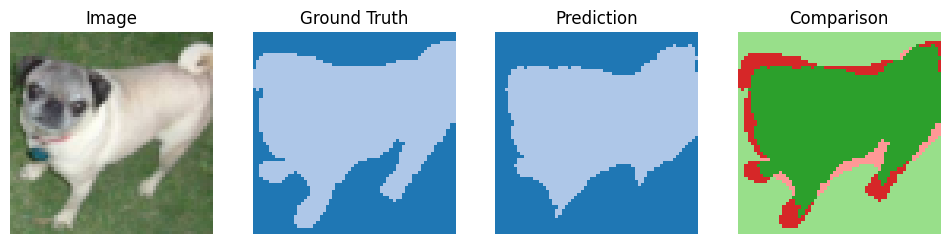

val epoch: 4 - iteration 11:
 - miou: 0.689256
 - dice: 0.815794
 - loss: 0.416387


train epoch: 5 - iteration 1:
 - miou: 0.708174
 - dice: 0.829020
 - loss: 0.405584


train epoch: 5 - iteration 22:
 - miou: 0.730123
 - dice: 0.843887
 - loss: 0.379726


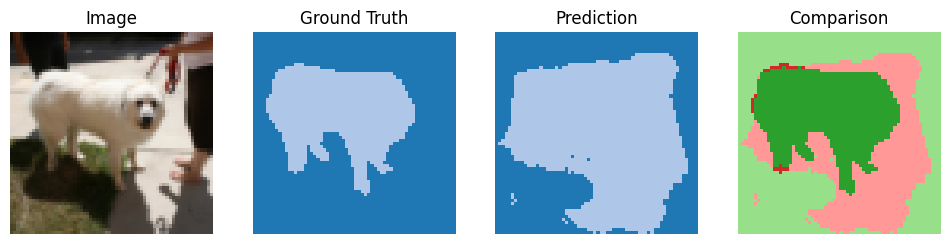

train epoch: 5 - iteration 44:
 - miou: 0.743896
 - dice: 0.852998
 - loss: 0.364620


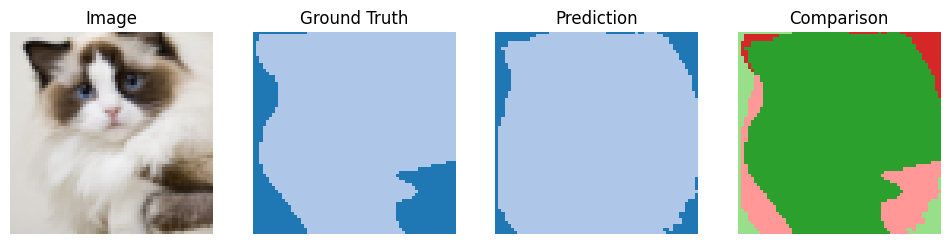

val epoch: 5 - iteration 1:
 - miou: 0.689913
 - dice: 0.816224
 - loss: 0.415304


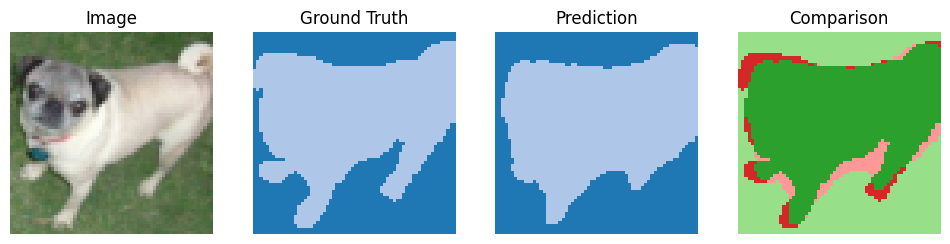

val epoch: 5 - iteration 11:
 - miou: 0.689943
 - dice: 0.816306
 - loss: 0.411055


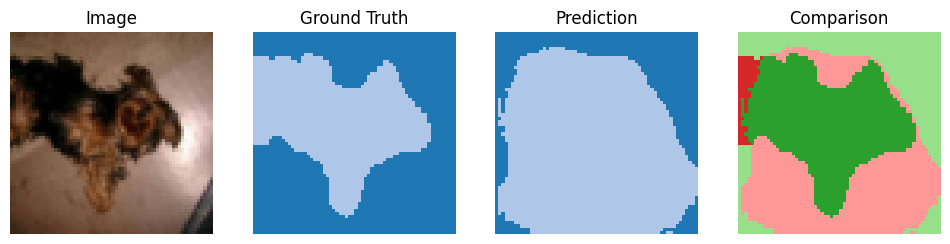

train epoch: 6 - iteration 1:
 - miou: 0.744554
 - dice: 0.853439
 - loss: 0.363385


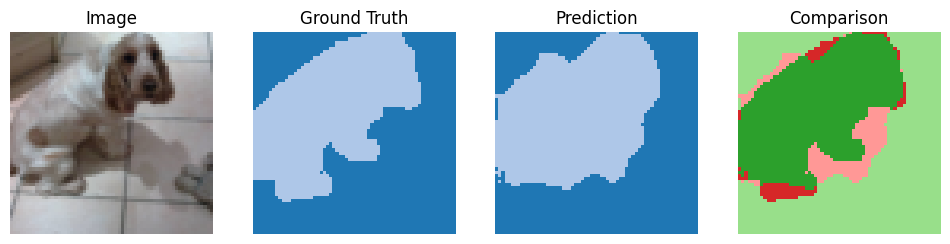

train epoch: 6 - iteration 22:
 - miou: 0.760014
 - dice: 0.863523
 - loss: 0.349778


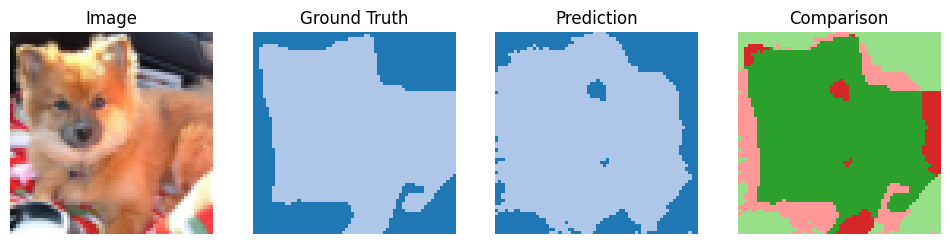

train epoch: 6 - iteration 44:
 - miou: 0.764399
 - dice: 0.866426
 - loss: 0.342997


val epoch: 6 - iteration 1:
 - miou: 0.690621
 - dice: 0.816748
 - loss: 0.410262


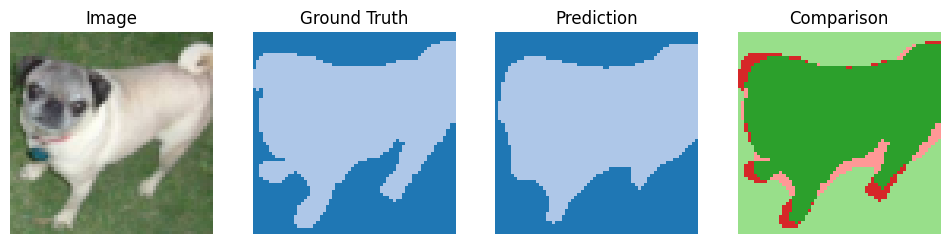

val epoch: 6 - iteration 11:
 - miou: 0.701698
 - dice: 0.824499
 - loss: 0.397657


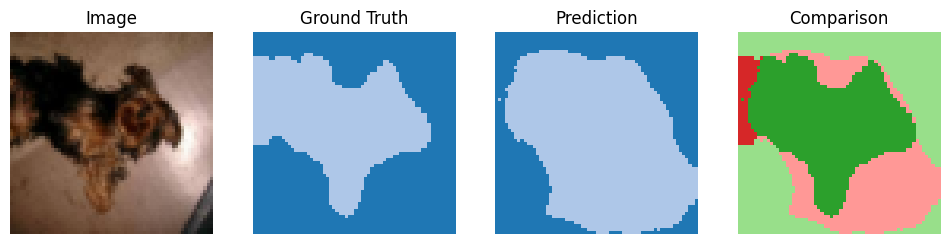

train epoch: 7 - iteration 1:
 - miou: 0.763633
 - dice: 0.865937
 - loss: 0.343357


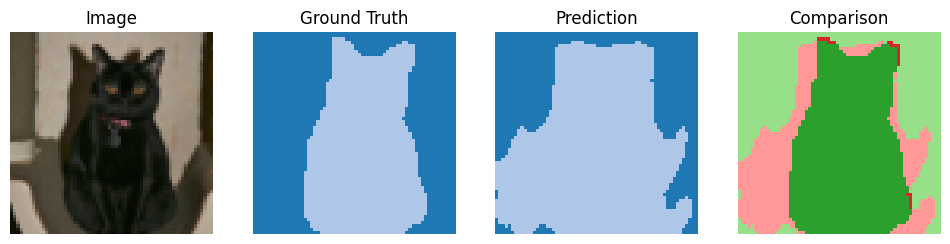

train epoch: 7 - iteration 22:
 - miou: 0.773982
 - dice: 0.872416
 - loss: 0.331296


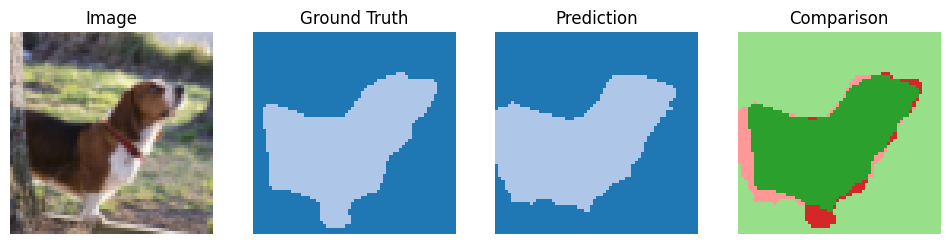

train epoch: 7 - iteration 44:
 - miou: 0.781397
 - dice: 0.877206
 - loss: 0.322743


val epoch: 7 - iteration 1:
 - miou: 0.703953
 - dice: 0.826034
 - loss: 0.396329


val epoch: 7 - iteration 11:
 - miou: 0.715195
 - dice: 0.833776
 - loss: 0.390538


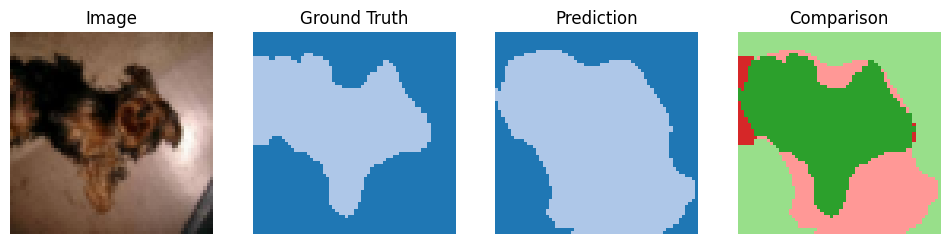

train epoch: 8 - iteration 1:
 - miou: 0.784483
 - dice: 0.879150
 - loss: 0.320464


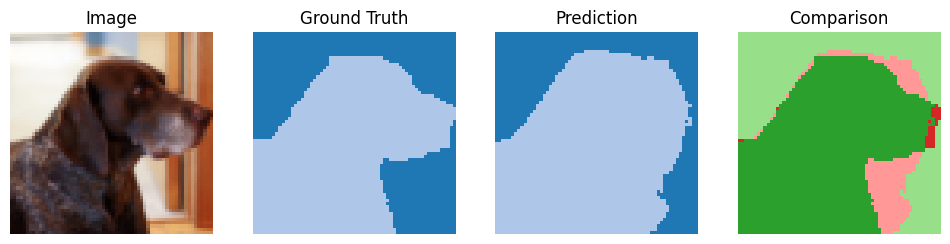

train epoch: 8 - iteration 22:
 - miou: 0.796639
 - dice: 0.886715
 - loss: 0.307355


train epoch: 8 - iteration 44:
 - miou: 0.790819
 - dice: 0.883165
 - loss: 0.312351


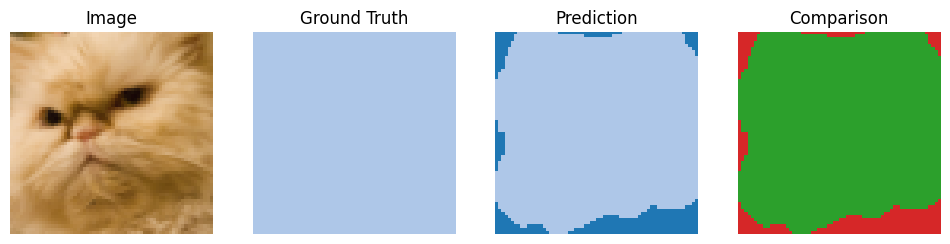

val epoch: 8 - iteration 1:
 - miou: 0.716889
 - dice: 0.834912
 - loss: 0.388213


val epoch: 8 - iteration 11:
 - miou: 0.719972
 - dice: 0.837075
 - loss: 0.379187


train epoch: 9 - iteration 1:
 - miou: 0.792968
 - dice: 0.884469
 - loss: 0.310873


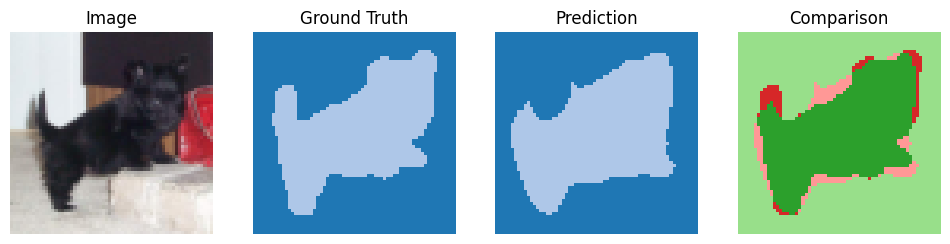

train epoch: 9 - iteration 22:
 - miou: 0.814185
 - dice: 0.897550
 - loss: 0.290903


train epoch: 9 - iteration 44:
 - miou: 0.800891
 - dice: 0.889408
 - loss: 0.299104


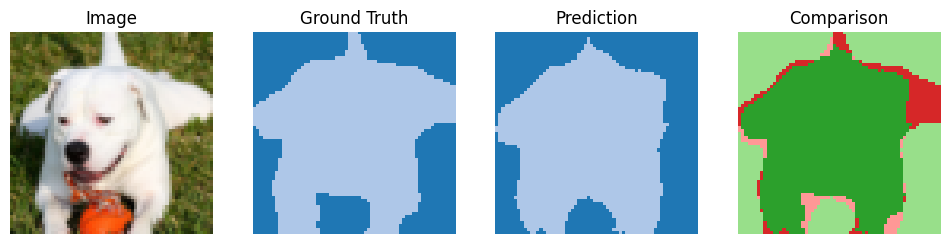

val epoch: 9 - iteration 1:
 - miou: 0.719481
 - dice: 0.836738
 - loss: 0.380158


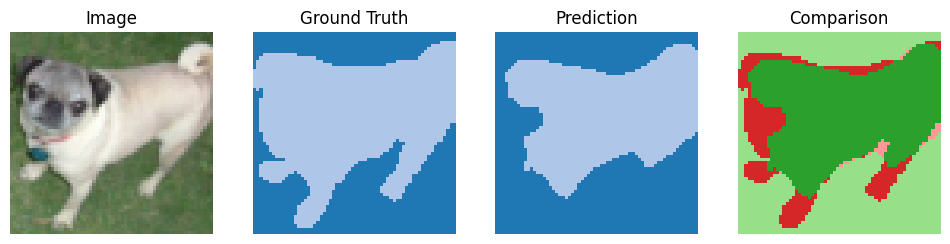

val epoch: 9 - iteration 11:
 - miou: 0.688743
 - dice: 0.815316
 - loss: 0.421940


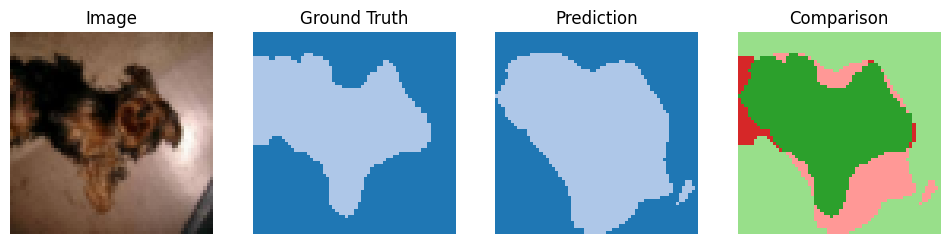

train epoch: 10 - iteration 1:
 - miou: 0.802218
 - dice: 0.890213
 - loss: 0.297911


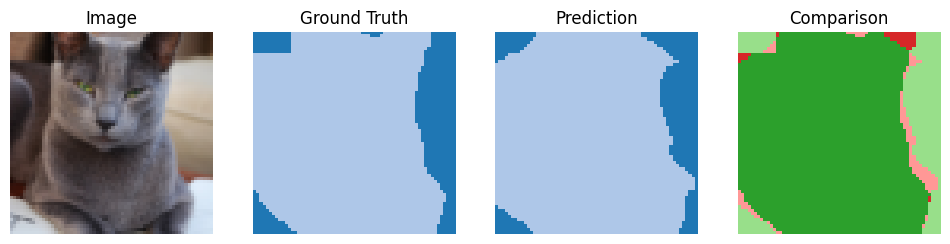

train epoch: 10 - iteration 22:
 - miou: 0.828837
 - dice: 0.906384
 - loss: 0.275314


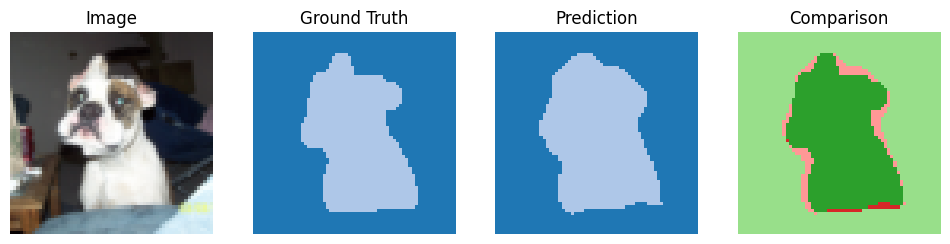

train epoch: 10 - iteration 44:
 - miou: 0.832715
 - dice: 0.908602
 - loss: 0.271919


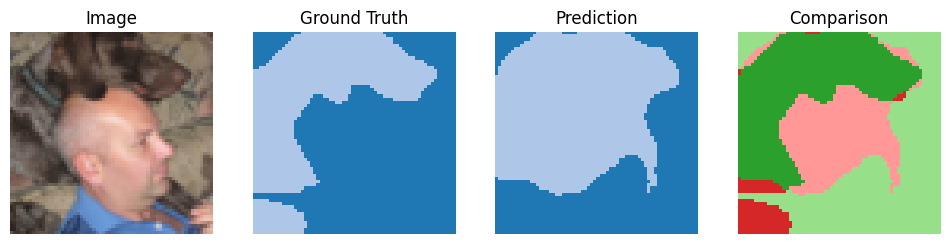

val epoch: 10 - iteration 1:
 - miou: 0.692692
 - dice: 0.818025
 - loss: 0.416802


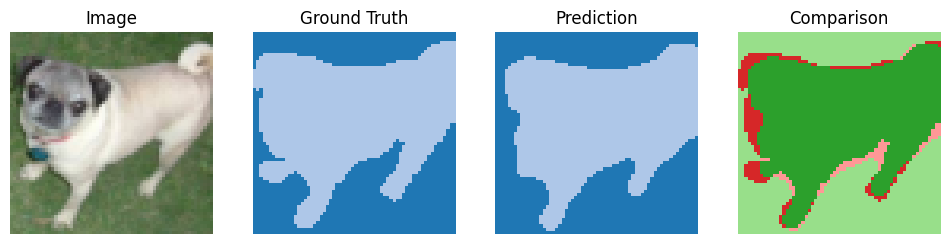

val epoch: 10 - iteration 11:
 - miou: 0.717336
 - dice: 0.835242
 - loss: 0.386340


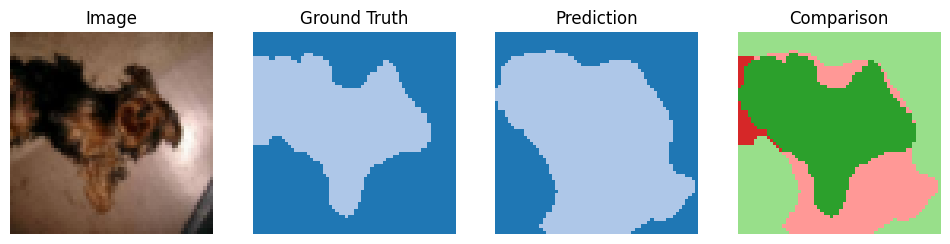

train epoch: 11 - iteration 1:
 - miou: 0.832039
 - dice: 0.908198
 - loss: 0.272576


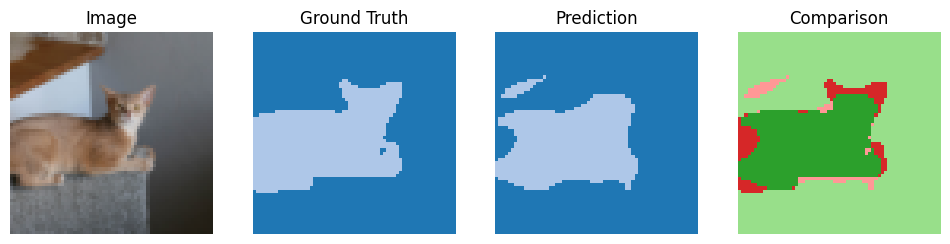

train epoch: 11 - iteration 22:
 - miou: 0.835540
 - dice: 0.910375
 - loss: 0.265907


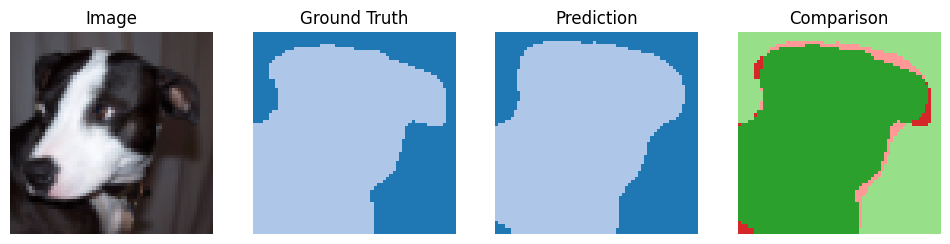

train epoch: 11 - iteration 44:
 - miou: 0.838862
 - dice: 0.912351
 - loss: 0.263262


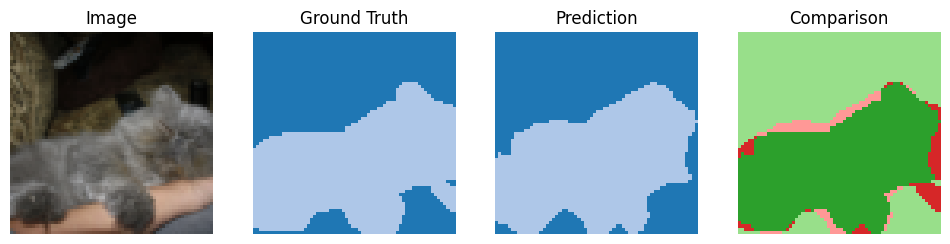

val epoch: 11 - iteration 1:
 - miou: 0.718447
 - dice: 0.835982
 - loss: 0.384533


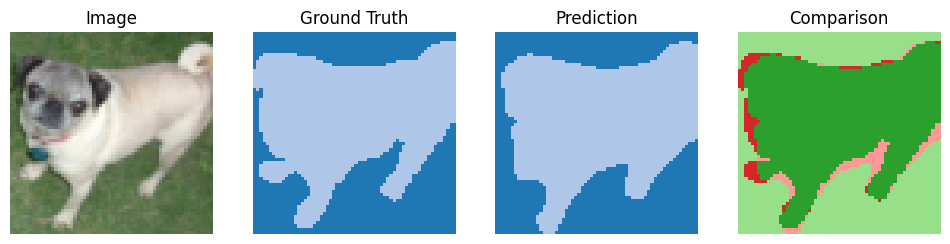

val epoch: 11 - iteration 11:
 - miou: 0.720583
 - dice: 0.837386
 - loss: 0.382199


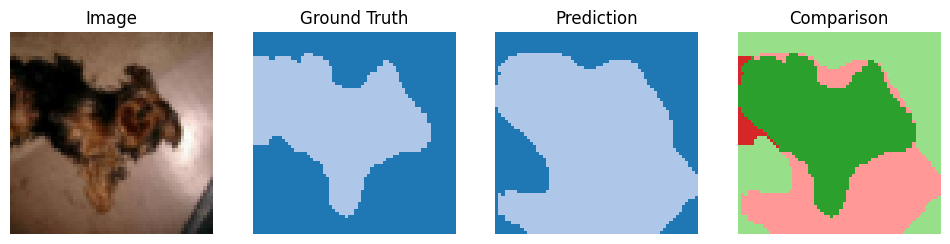

train epoch: 12 - iteration 1:
 - miou: 0.840174
 - dice: 0.913124
 - loss: 0.262170


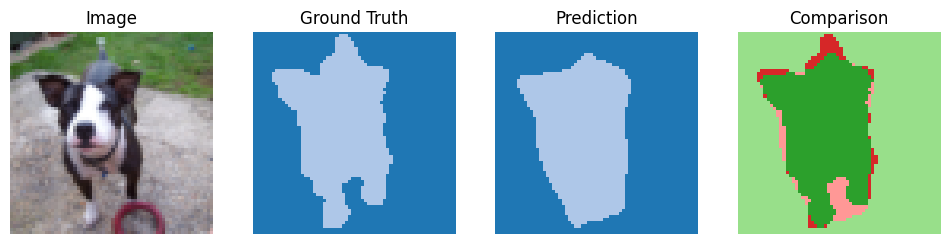

train epoch: 12 - iteration 22:
 - miou: 0.847491
 - dice: 0.917402
 - loss: 0.255565


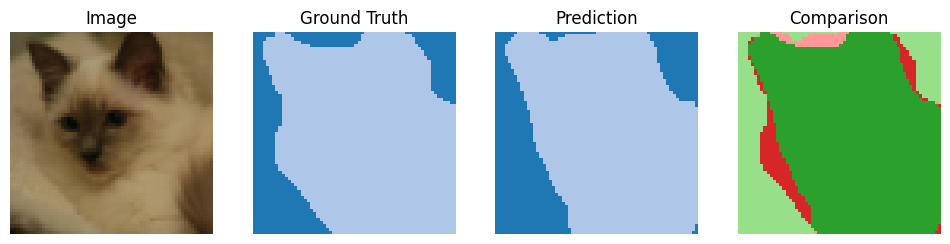

train epoch: 12 - iteration 44:
 - miou: 0.845577
 - dice: 0.916298
 - loss: 0.254309


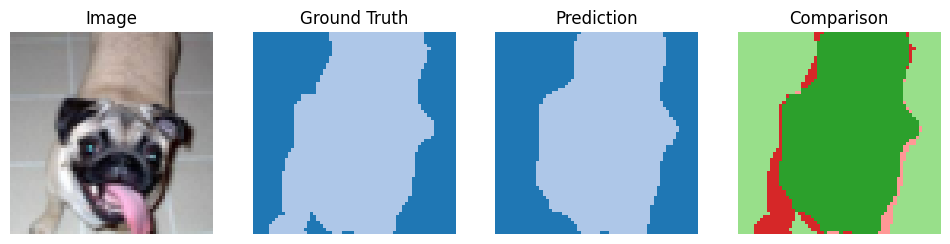

val epoch: 12 - iteration 1:
 - miou: 0.720941
 - dice: 0.837616
 - loss: 0.380914


val epoch: 12 - iteration 11:
 - miou: 0.720315
 - dice: 0.837344
 - loss: 0.379846


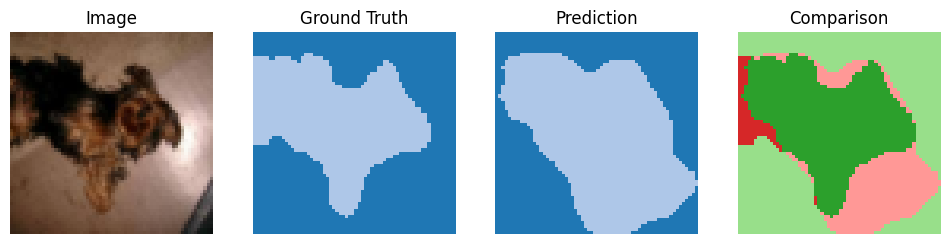

train epoch: 13 - iteration 1:
 - miou: 0.846597
 - dice: 0.916895
 - loss: 0.253384


train epoch: 13 - iteration 22:
 - miou: 0.859441
 - dice: 0.924367
 - loss: 0.242988


train epoch: 13 - iteration 44:
 - miou: 0.858875
 - dice: 0.924047
 - loss: 0.241435


val epoch: 13 - iteration 1:
 - miou: 0.721270
 - dice: 0.837993
 - loss: 0.379215


val epoch: 13 - iteration 11:
 - miou: 0.710137
 - dice: 0.830315
 - loss: 0.400959


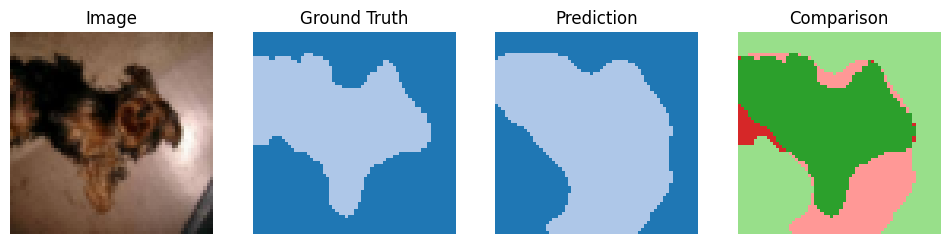

train epoch: 14 - iteration 1:
 - miou: 0.857600
 - dice: 0.923316
 - loss: 0.242640


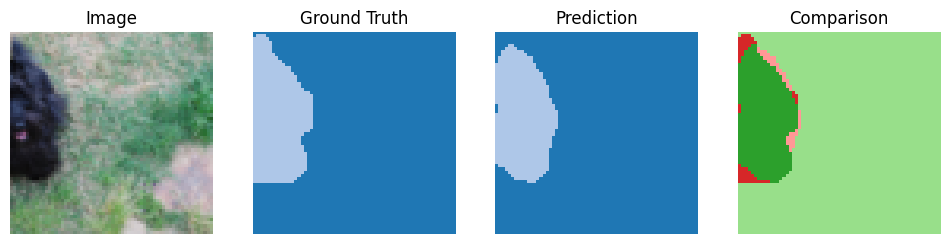

train epoch: 14 - iteration 22:
 - miou: 0.870111
 - dice: 0.930514
 - loss: 0.232785


train epoch: 14 - iteration 44:
 - miou: 0.864648
 - dice: 0.927369
 - loss: 0.234105


val epoch: 14 - iteration 1:
 - miou: 0.712454
 - dice: 0.831881
 - loss: 0.397006


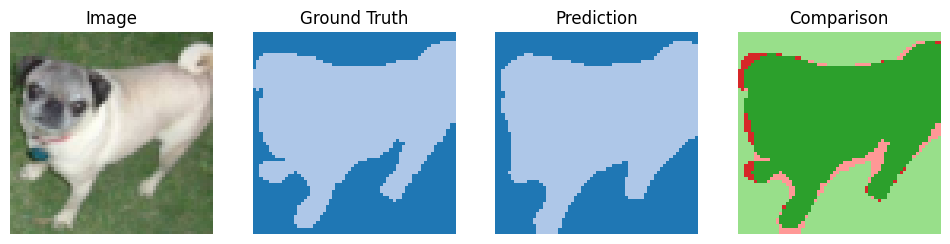

val epoch: 14 - iteration 11:
 - miou: 0.721119
 - dice: 0.837815
 - loss: 0.378581


train epoch: 15 - iteration 1:
 - miou: 0.863948
 - dice: 0.926967
 - loss: 0.235044


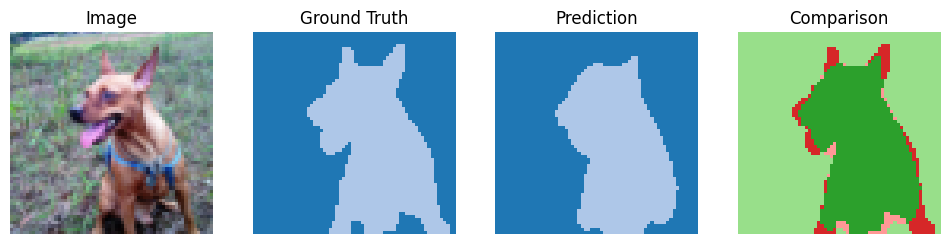

train epoch: 15 - iteration 22:
 - miou: 0.870681
 - dice: 0.930858
 - loss: 0.229183


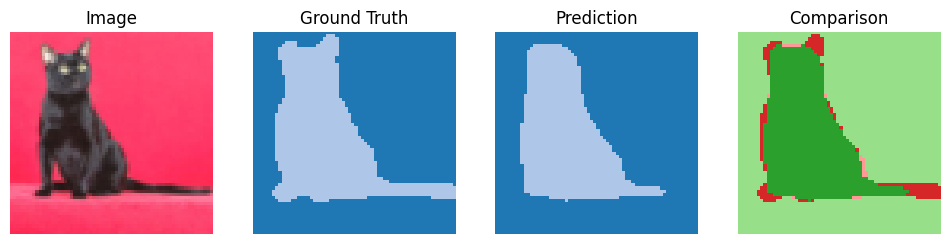

train epoch: 15 - iteration 44:
 - miou: 0.872162
 - dice: 0.931703
 - loss: 0.226226


val epoch: 15 - iteration 1:
 - miou: 0.722195
 - dice: 0.838543
 - loss: 0.377684


val epoch: 15 - iteration 11:
 - miou: 0.718885
 - dice: 0.836291
 - loss: 0.388564


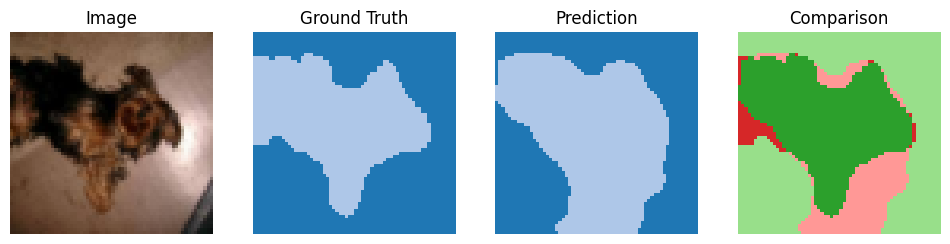

In [99]:
trainer = SegmentationTrainer(model, optimizer, log_iterations={"train": 22, "val": 11}, device=device)

for epoch in range(15):
    trainer.train_loader(train_loader, epoch)
    trainer.validate_loader(val_loader, epoch)

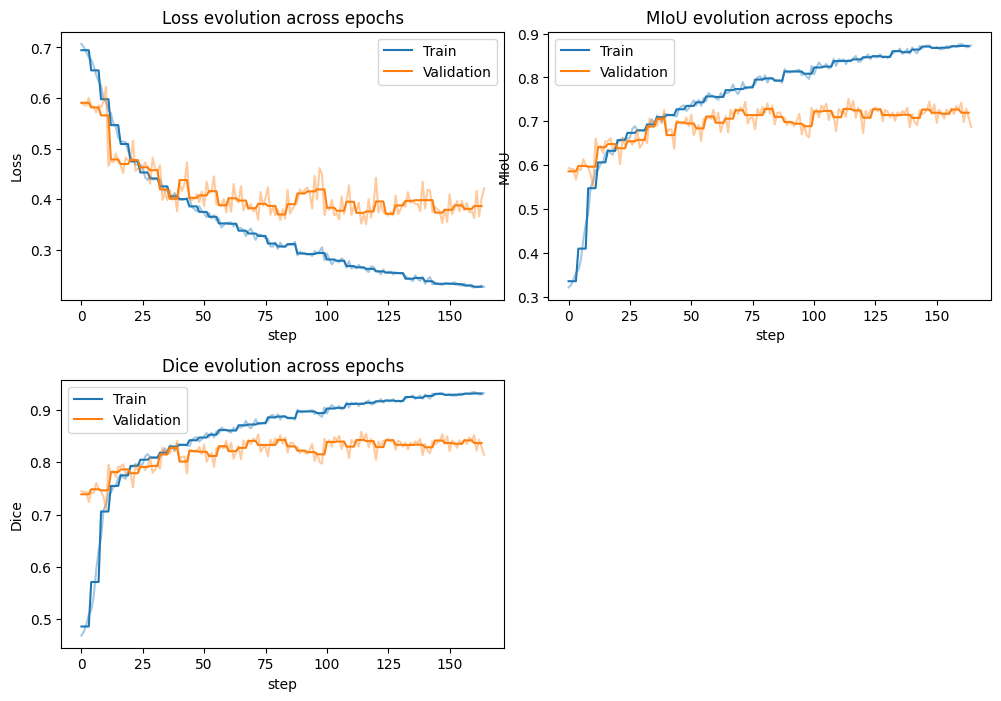

In [100]:
vtk.plot_stats(trainer.stats, attenuation=4)

## Evaluarea modelului antrenat

In [31]:
#TODO: Folosind setul de date de testare, evaluează performanța modelului antrenat


### Hai să creăm propria mască! Cât de bine te-ai descurcat?

* descarcă imaginea de mai jos și deschide-o în Paint
* creează o mască folosind alb pentru animal și negru pentru fundal

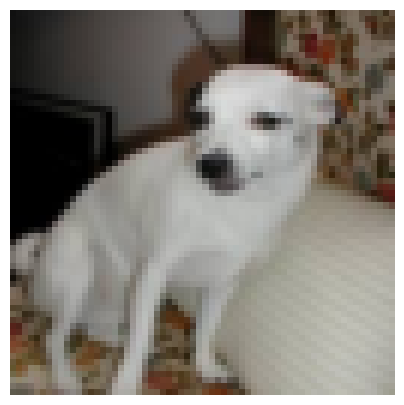

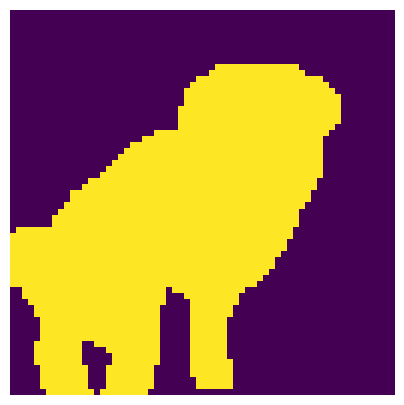

In [32]:
image_idx = 0
for (images, masks) in test_loader:
    ex_img = images[image_idx].numpy()
    ex_mask = masks[image_idx].numpy()
    vtk.visualize_image(
      postprocess_img(ex_img)
    )
    vtk.visualize_image(
      postprocess_mask(ex_mask)
    )
    break

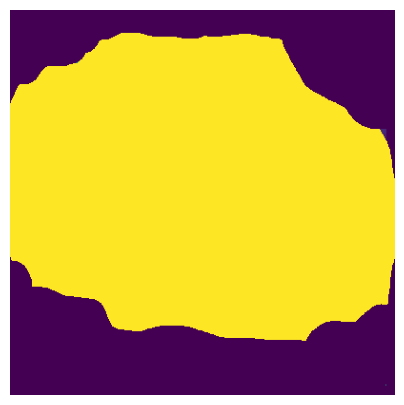

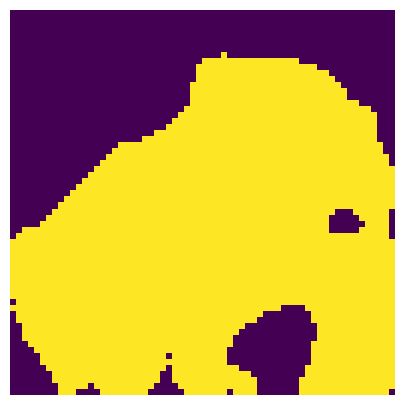

MIoU: 0.42810828550520724 0.46961267003077867
Dice: 0.5987030785593872 0.629718743907999
Pixel Accuracy: 0.6015625 0.664306640625


In [44]:
#TODO: Încarcă masca creată de tine și evalueaz-o

my_img_path = "/content/test.png" # schimbă numele imaginii
my_image = np.array(Image.open(my_img_path).convert("L")) / 255.0
vtk.visualize_image(my_image)

# Aducem masca creată la aceleași dimensiuni cu masca originală
my_image = torch.from_numpy(my_image).unsqueeze(0).float()
my_image = transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST)(my_image)
my_image = my_image.to(trainer.device)
my_image = my_image.squeeze()

for idx, (images, masks) in enumerate(test_loader):
    if idx == image_idx:
        image = images[0].unsqueeze(0).to(trainer.device)
        mask = masks[0].unsqueeze(0).to(trainer.device)

        with torch.no_grad():
            pred = trainer.model(image)
            pred = pred > 0.5
            vtk.visualize_image(postprocess_mask(pred.cpu().numpy()))

        # Predicted Mask vs Ground Truth
        miou_pred = compute_miou(my_image.cpu().numpy(), pred.cpu().numpy().squeeze())
        dice_pred = compute_dice(my_image.cpu().numpy(), pred.cpu().numpy().squeeze())
        pixel_acc_pred = compute_pixel_acc(my_image.cpu().numpy(), pred.cpu().numpy().squeeze())

        # My Mask vs Ground Truth
        miou_my_mask = compute_miou(my_image.cpu().numpy(), mask.cpu().numpy().squeeze())
        dice_my_mask = compute_dice(my_image.cpu().numpy(), mask.cpu().numpy().squeeze())
        pixel_acc_my_mask = compute_pixel_acc(my_image.cpu().numpy(), mask.cpu().numpy().squeeze())

        print("MIoU:", miou_my_mask, miou_pred)
        print("Dice:", dice_my_mask, dice_pred)
        print("Pixel Accuracy:", pixel_acc_my_mask, pixel_acc_pred)
        break

### Resurse

* https://poloclub.github.io/cnn-explainer/
* https://www.v7labs.com/blog/image-segmentation-guide
* https://www.robots.ox.ac.uk/~vgg/data/pets/
* https://docs.pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html
* https://www.w3schools.com/colors/colors_picker.asp
* https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient